# Analysis of action potential waveforms

This notebook applies a pacing protocol to the Nygren and Courtemanche action potential models and compares the action potentials and major ion currents in after the final stimulation.

In [579]:
import myokit
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyabc
import pymc3
import pandas as pd

In [580]:
from ionchannelABC.experiment import setup

In [581]:
%matplotlib inline

In [582]:
def make_ap_measurements(d):
    V = d['membrane.V']
    time = d['environment.time']

    rest = V[0]
    ampl = max(V)-rest
    peak_index = np.nonzero(np.array(V) == max(V))[0][0]
    apd90 = np.inf
    for i, v in enumerate(V[peak_index:]):
        if v <= (rest+ampl*0.1):
            apd90 = time[peak_index+i]
            break
    
    return [rest, ampl, apd90]

In [624]:
def make_output(sim, protocol, model, channel, samples, 
                cond_factors, log_interval, ap_offset,
                log_vars, npulses=100):
    
    if 'membrane.V' not in log_vars:
        log_vars = log_vars + ['membrane.V']
    
    output = pd.DataFrame({})
    ap_df_out = pd.DataFrame({})
    ap_measurements = []
    
    for i, sample in enumerate(samples):
        
        sim.reset()
        for p, v in sample.items():
            name = p
            value = v
            if p.startswith("log"):
                name = p[4:]
                value = 10**v
            sim.set_constant(name, value)
        sim.set_constant(channel+'.cond_factor', cond_factors[i])
        
        try:
            data = sim.run(protocol.characteristic_time(), log_interval=log_interval)
        except:
            continue
        data = data.trim((npulses-1)*period+offset, (npulses-1)*period+offset+ap_offset, adjust=True)
        output_df = {'environment.time': data['environment.time'],
                     'membrane.V': data['membrane.V'],
                     'sample': i}
        for var in log_vars:
            output_df[var] = data[var]
        output_df = pd.DataFrame(output_df)
        output = output.append(output_df, ignore_index=True)
        
        ap_measurements.append(make_ap_measurements(data))
        
    ap_measurements = np.array(ap_measurements)
    model_list = [model,]*ap_measurements.shape[0]
    ap_df = pd.DataFrame({'RP': ap_measurements[:,0],
                          'AMP': ap_measurements[:,1],
                          'APD90': ap_measurements[:,2],
                          'model': model_list})
    ap_df_out = ap_df_out.append(ap_df, ignore_index=True)
        
    return output, ap_df_out

In [1165]:
def calc_hpd(data, credible_interval=0.89):
    hpd = np.zeros((3,2))
    for i, measure in enumerate(['RP', 'AMP', 'APD90']):
        hpd[i,:] = pymc3.hpd(data[measure], credible_interval=credible_interval)
    return hpd

In [728]:
def plot_ap_measurements(ap_measurements, original):
    sns.reset_orig()
    sns.set_context('poster')
    sns.set_style("whitegrid")
    mpl.rcParams['font.size'] = 14
    
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
    sns.despine(bottom=True)
    
    keys = ['RP', 'AMP', 'APD90']
    units = ['mV', 'mV', 'ms']

    for i, (key, unit) in enumerate(zip(keys, units)):
        sns.stripplot(x='model', y=key, hue='model', data=ap_measurements, 
                      dodge=True, jitter=True, alpha=.25, zorder=1,
                      palette='deep', ax=ax[i])
        sns.pointplot(x='model', y=key, hue='model', data=ap_measurements,
                      dodge=.532, join=False, palette="dark",
                      estimator=np.median,
                      markers="d", scale=.75, ci=None, ax=ax[i]) 
        sns.pointplot(x='model', y=key, hue='model', data=original,
                      dodge=.532, join=False, palette="dark",
                      markers="x", scale=.75, ci=None, ax=ax[i])
        ax[i].get_legend().remove()
        ax[i].set_ylabel(key+' (' + unit + ')')
        
        
    return fig

In [1054]:
def plot_model(samples, original, keys, highlight=None):
    sns.reset_orig()
    sns.set_context('poster')
    mpl.rcParams['font.size'] = 14
    
    fig, ax = plt.subplots(ncols=len(keys)+1, nrows=1,
                           figsize=(7.5*(len(keys)+1), 5))
    sns.despine(top=True, right=True)
    
    data = samples
    
    sns.relplot(x='environment.time', y='membrane.V', data=samples,
                kind='line', estimator=np.median,
                ci=None, ax=ax[0])
    hpd = np.zeros((len(data['environment.time'].unique()), 2))
    for j, tj in enumerate(data['environment.time'].unique()):
        data_tj = data[data['environment.time']==tj]
        hpd[j,:] = pymc3.hpd(data_tj['membrane.V'], credible_interval=0.89)
    ax[0].fill_between(data['environment.time'].unique(), hpd[:,0], hpd[:,1], alpha=0.4)
    ax[0].plot(original['environment.time'], original['membrane.V'], linestyle='--')
    ax[0].set_xlabel('time (ms)')
    ax[0].set_ylabel('voltage (mV)')
    
    for i, key in enumerate(keys):
        color='C0'
        if highlight is not None and key == highlight:
            color='C1'
        sns.relplot(x='environment.time', y=key, data=samples,
                    kind='line', estimator=np.median, color=color,
                    ci=None, ax=ax[i+1])
        hpd = np.zeros((len(data['environment.time'].unique()), 2))
        for j, tj in enumerate(data['environment.time'].unique()):
            data_tj = data[data['environment.time']==tj]
            hpd[j,:] = pymc3.hpd(data_tj[key], credible_interval=0.89)

        ax[i+1].fill_between(data['environment.time'].unique(), hpd[:,0], hpd[:,1], 
                             color=color, alpha=0.4)
        ax[i+1].plot(original['environment.time'], original[key], linestyle='--',
                     color=color)
        
        ax[i+1].set_xlabel('time (ms)')
        ax[i+1].set_ylabel(key.split('.')[1])

    plt.tight_layout()
        
    return fig

In [586]:
#nyg = myokit.load_model('models/nygren.mmt') # unedited model
nyg = myokit.load_model('models/nygren_variability.mmt')
#cou = myokit.load_model('models/courtemanche.mmt') # unedited model
cou = myokit.load_model('models/courtemanche_variability.mmt')

The models have different membrane capacitance values so we apply a different stimulus current in either case to get the same value in pA/pF.

In [587]:
Cm_nyg = nyg.get('membrane.Cm').value()*1e3 # pF
Cm_cou = cou.get('membrane.Cm').value()     # pF

#### Courtemanche

In [588]:
# 1 Hz pacing protocol
npulses = 100
period = 1000 # ms
duration = 1 # ms
level = -4000 # pA => -4000/100 = -40 pA/pF
offset = 1e4 # ms

pulsetrain_cou = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

In [589]:
pace = cou.get('membrane.i_st')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [590]:
cou_sim = myokit.Simulation(cou, pulsetrain_cou)

In [591]:
data_cou = cou_sim.run(pulsetrain_cou.characteristic_time())
# Get only the last pulse
data_cou_trimmed_12 = data_cou.trim(11*period+offset, 11*period+offset+400, adjust=True)
data_cou_trimmed_100 = data_cou.trim(99*period+offset, 99*period+offset+400, adjust=True)
#data_cou_trimmed_1000 = data_cou.trim((npulses-1)*period+offset, (npulses-1)*period+offset+400, adjust=True)

In [592]:
make_ap_measurements(data_cou_trimmed_12)

[-80.87623863664844, 111.68308358049109, 295.33988470686745]

In [593]:
cou_ap_original = make_ap_measurements(data_cou_trimmed_100)
cou_ap_original = pd.DataFrame({'RP': [cou_ap_original[0]],
                                'AMP': [cou_ap_original[1]],
                                'APD90': [cou_ap_original[2]],
                                'model': ['C']})
cou_s_ap_original = cou_ap_original.copy()
cou_s_ap_original['model'] = 'C+S'

In [594]:
cou_ap_original

RP         AMP       APD90 model
0 -81.172067  110.942165  288.453603     C

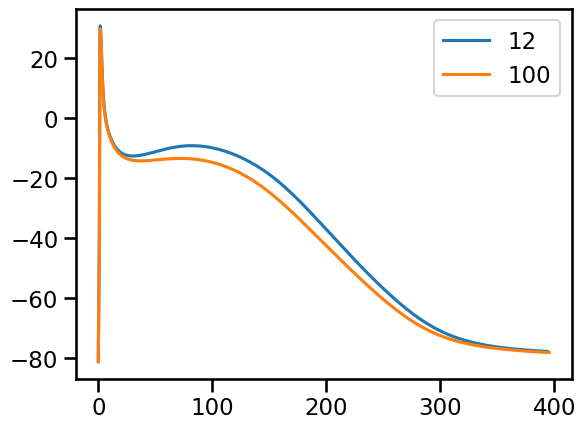

In [597]:
sns.reset_orig()
sns.set_context('talk')
fig, ax = plt.subplots()
ax.plot(data_cou_trimmed_12['environment.time'], data_cou_trimmed_12['membrane.V'], label='12')
ax.plot(data_cou_trimmed_100['environment.time'], data_cou_trimmed_100['membrane.V'], label='100')
#ax.plot(data_cou_trimmed_1000['environment.time'], data_cou_trimmed_1000['membrane.V'], label='1000')
ax.legend()

In [600]:
data_cou = data_cou_trimmed_100
data_cou_original = data_cou_trimmed_100

In [670]:
cou_log_vars = ['intracellular_ion_concentrations.Ca_i', 'ina.i_Na', 'ical.i_CaL', 'ito.i_to', 'isus.i_sus']

In [675]:
data_cou_original = pd.DataFrame(data_cou_original)

In [676]:
for var in cou_log_vars:
    if var.split('.')[1][0]=='i':
        data_cou_original[var] /= Cm_cou

#### Nygren

In [601]:
# 1 Hz pacing protocol
npulses = 100
period = 1 # s
duration = 1e-3 # s
level = -2000 # pA -> -2000/50 = -40 pA/pF
offset = 10 # s

pulsetrain_nyg = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

In [602]:
pace = nyg.get('membrane.i_Stim')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
nyg_sim = myokit.Simulation(nyg, pulsetrain_nyg)

In [603]:
data_nyg_original = nyg_sim.run(pulsetrain_nyg.characteristic_time())
data_nyg_original = data_nyg_original.trim((npulses-1)*period+offset, (npulses-1)*period+offset+0.4, adjust=True)

In [644]:
data_nyg_original = pd.DataFrame(data_nyg_original)

In [646]:
data_nyg_original['environment.time'] *= 1e3

In [753]:
nyg_log_vars = ['intracellular_ion_concentrations.Ca_i','ina.i_Na', 'ical.i_CaL', 'ito.i_to', 'isus.i_sus']

In [647]:
for var in nyg_log_vars:
    if var.split('.')[1][0] == 'i': # currents
        data_nyg_original[var] /= Cm_nyg

In [604]:
nyg_ap_original = make_ap_measurements(data_nyg_original)
nyg_ap_original = pd.DataFrame({'RP': [nyg_ap_original[0]],
                                'AMP': [nyg_ap_original[1]],
                                'APD90': [nyg_ap_original[2]],
                                'model': ['N']})
nyg_ap_original['APD90'] *= 1e3
nyg_s_ap_original = nyg_ap_original.copy()
nyg_s_ap_original['model'] = 'N+S'

In [605]:
nyg_ap_original

RP         AMP       APD90 model
0 -74.110697  114.301224  223.178334     N

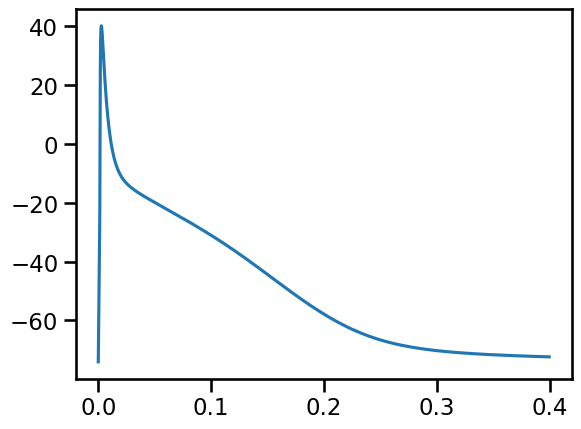

In [606]:
plt.plot(data_nyg_original['environment.time'], data_nyg_original['membrane.V'])

In [607]:
data_nyg = data_nyg_original

#### Comparison

In [27]:
data_cou_ina = data_cou.trim_right(5)
data_nyg_ina = data_nyg.trim_right(5e-3)
data_cou_ical = data_cou.trim_right(20)
data_nyg_ical = data_nyg.trim_right(20e-3)
data_cou_ik = data_cou.trim_right(15)
data_nyg_ik = data_nyg.trim_right(15e-3)

KeyError: 'sodium_current.i_Na'

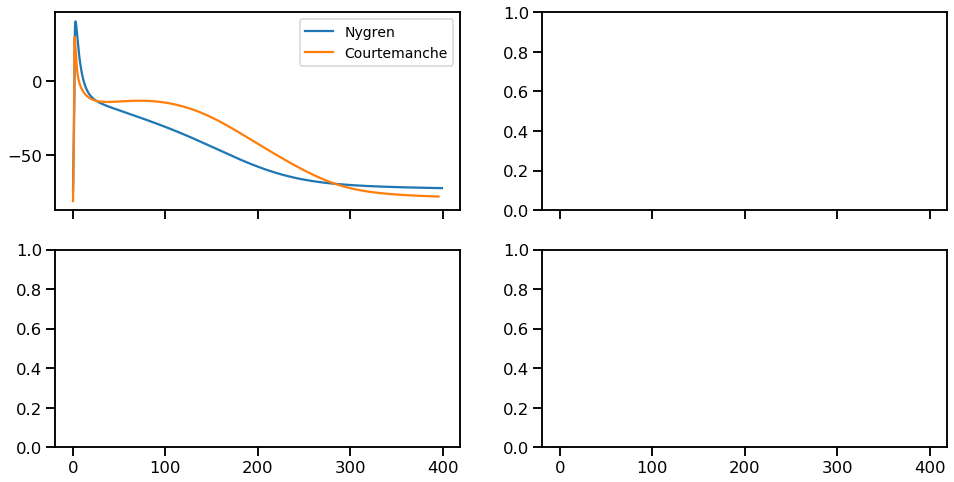

In [26]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(16, 8))
ax = ax.flatten()

# Action potential
ax[0].plot(np.array(data_nyg['environment.time'])*1000, data_nyg['membrane.V'], label='Nygren')
ax[0].plot(data_cou['environment.time'], data_cou['membrane.V'], label='Courtemanche')
ax[0].legend(loc='upper right')

# Sodium current
ax[1].plot(np.array(data_nyg['environment.time'])*1000, 
           np.array(data_nyg['ina.i_Na'])/Cm_nyg)
ax[1].plot(data_cou['environment.time'], 
           np.array(data_cou['ina.i_Na'])/Cm_cou)
ax[1].fill_between([0., 8.], ax[1].get_ylim()[0], ax[1].get_ylim()[1],
                   facecolor='k', alpha=0.2)

ax_ina = plt.axes([.75, .65, .125, .2*1.25])
plt.plot(np.array(data_nyg_ina['environment.time'])*1000, 
         np.array(data_nyg_ina['ina.i_Na'])/Cm_nyg)
plt.plot(data_cou_ina['environment.time'],
         np.array(data_cou_ina['ina.i_Na'])/Cm_cou)
ax_ina.set_xlabel('')
ax_ina.set_ylabel('')

# Calcium current
ax[2].plot(np.array(data_nyg['environment.time'])*1000, 
           np.array(data_nyg['ical.i_CaL'])/Cm_nyg)
ax[2].plot(data_cou['environment.time'], 
           np.array(data_cou['ical.i_CaL'])/Cm_cou)
ax[2].fill_between([0., 20.], ax[2].get_ylim()[0], ax[2].get_ylim()[1],
                   facecolor='k', alpha=0.2)

ax_ical = plt.axes([.25, .2, .125, .2*1.25])
plt.plot(np.array(data_nyg_ical['environment.time'])*1000, 
         np.array(data_nyg_ical['ical.i_CaL'])/Cm_nyg)
plt.plot(data_cou_ical['environment.time'],
         np.array(data_cou_ical['ical.i_CaL'])/Cm_cou)
ax_ical.set_xlabel('')
ax_ical.set_ylabel('')

# Potassium currents
ax[3].plot(np.array(data_nyg['environment.time'])*1000, 
           (np.array(data_nyg['ito.i_to'])+
           np.array(data_nyg['isus.i_sus']))/Cm_nyg)
ax[3].plot(data_cou['environment.time'], 
           (np.array(data_cou['ito.i_to'])+
           np.array(data_cou['isus.i_sus']))/Cm_cou)
ax[3].fill_between([0., 15.], ax[3].get_ylim()[0], ax[3].get_ylim()[1],
                   facecolor='k', alpha=0.2)

ax_ik = plt.axes([.75, .2, .125, .2*1.25])
plt.plot(np.array(data_nyg_ik['environment.time'])*1000, 
         (np.array(data_nyg_ik['ito.i_to'])+
          np.array(data_nyg_ik['isus.i_sus']))/Cm_nyg)
plt.plot(data_cou_ik['environment.time'],
         (np.array(data_cou_ik['ito.i_to'])+
           np.array(data_cou_ik['isus.i_sus']))/Cm_cou)
ax_ik.set_xlabel('')
ax_ik.set_ylabel('')

ax[2].set_xlabel('time (ms)')
ax[3].set_xlabel('time (ms)')
ax[0].set_ylabel('transmembrane\nvoltage (mV)')
ax[1].set_ylabel('$I_{Na}$ (A/F)')
ax[2].set_ylabel('$I_{CaL}$ (A/F)')
ax[3].set_ylabel('$I_{to} + I_{Kur}$ (A/F)')

plt.tight_layout()

In [19]:
#fig.savefig('figures/supp_fig_1.pdf')

## Variability

### $I_\mathrm{CaL}$ - NYG

In [608]:
# 1 Hz pacing protocol
npulses = 100
period = 1 # s
duration = 1e-3 # s
level = -2000 # pA -> -2000/50 = -40 pA/pF
offset = 10 # s

pulsetrain_nyg = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = nyg.get('membrane.i_Stim')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
nyg_sim = myokit.Simulation(nyg, pulsetrain_nyg)

In [609]:
# Match peak of i_CaL current during IV experiment

In [610]:
from experiments.ical_li import li_iv_80

In [611]:
observations, model, summary_statistics = setup('models/nygren_ical.mmt',
                                                li_iv_80)

In [612]:
original_peak = max(model({})[0]['ical.i_CaL'], key=abs) # from original model

In [614]:
original_peak # pA

-221.3283838258063

In [615]:
h_nyg_d_unified = pyabc.History('sqlite:///results/nygren/ical/unified/nygren_ical_dgate_unified.db')
h_nyg_f_original = pyabc.History('sqlite:///results/nygren/ical/original/nygren_ical_fgates_original.db')

In [616]:
df_nyg_d_unified, w_nyg_d_unified = h_nyg_d_unified.get_distribution(m=0)
df_nyg_f_original, w_nyg_f_original = h_nyg_f_original.get_distribution(m=0)

In [617]:
N = 100
nyg_par_samples_d_unified = df_nyg_d_unified.sample(n=N, weights=w_nyg_d_unified, replace=True)
nyg_par_samples_d_unified = nyg_par_samples_d_unified.set_index([pd.Index(range(N))])
nyg_par_samples_f_original = df_nyg_f_original.sample(n=N, weights=w_nyg_f_original, replace=True)
nyg_par_samples_f_original = nyg_par_samples_f_original.set_index([pd.Index(range(N))])

nyg_samples_ical = (pd.concat([nyg_par_samples_d_unified, 
                                      nyg_par_samples_f_original], axis=1)
                           .to_dict(orient='records'))

In [618]:
peaks = []
for sample in nyg_samples_ical:
    peaks.append(max(model(sample)[0]['ical.i_CaL'], key=abs))

In [619]:
cond_factors_nyg_ical = [original_peak/p for p in peaks]

In [620]:
print(cond_factors_nyg_ical)

[0.9355768116318754, 0.9528336509804098, 0.9781376640452587, 0.9601279747403626, 0.9103706403565356, 0.9155524940771588, 0.8557740347493357, 1.0729112851347187, 0.8611369266280269, 1.134821750553411, 0.8065573325131441, 0.8698505217722334, 1.0171902198852378, 0.9268496602315203, 0.9884033139761518, 1.209801781931708, 1.1486047495324985, 0.9437469405094117, 1.045610763537142, 1.0382576570820827, 0.8979189801925217, 1.2166862100365876, 1.2079623617626751, 1.0030474137367644, 1.0128310632903819, 1.018031610659698, 1.0271733919065038, 0.9113832948229336, 0.8987083239987078, 1.005459390732003, 1.2323146900005875, 0.8839899828652585, 0.9183207866863252, 0.9600928243827168, 0.8580253864756846, 0.8824262336920692, 0.875047867408598, 0.8705775085035972, 0.9300571656743368, 0.959972733671032, 1.0050445850257648, 1.1147545877028633, 1.03458735656566, 1.0996245237626718, 0.9026813979908405, 0.9059839629244657, 1.0894882319823835, 0.8627625542226216, 1.1516006744882155, 0.97897322791857, 0.94254228

In [628]:
nyg_output_ical, nyg_ap_ical = make_output(nyg_sim, pulsetrain_nyg, 'N', 'ical', nyg_samples_ical,
                                           cond_factors_nyg_ical, log_interval=0.001, ap_offset=0.4,
                                           log_vars=nyg_log_vars)

In [630]:
nyg_ap_ical['APD90'] = nyg_ap_ical['APD90']*1e3

In [631]:
nyg_ap_ical.median()

RP       -73.690062
AMP      113.440160
APD90    217.500000
dtype: float64

In [638]:
nyg_output_ical['environment.time'] *= 1e3

In [640]:
for var in nyg_log_vars:
    if var.split('.')[1][0]=='i':
        nyg_output_ical[var] /= Cm_nyg

In [1167]:
calc_hpd(nyg_ap_ical)

array([[-76.27938269, -17.50700605],
       [ 38.99596933, 115.82958945],
       [ 16.        , 295.        ]])

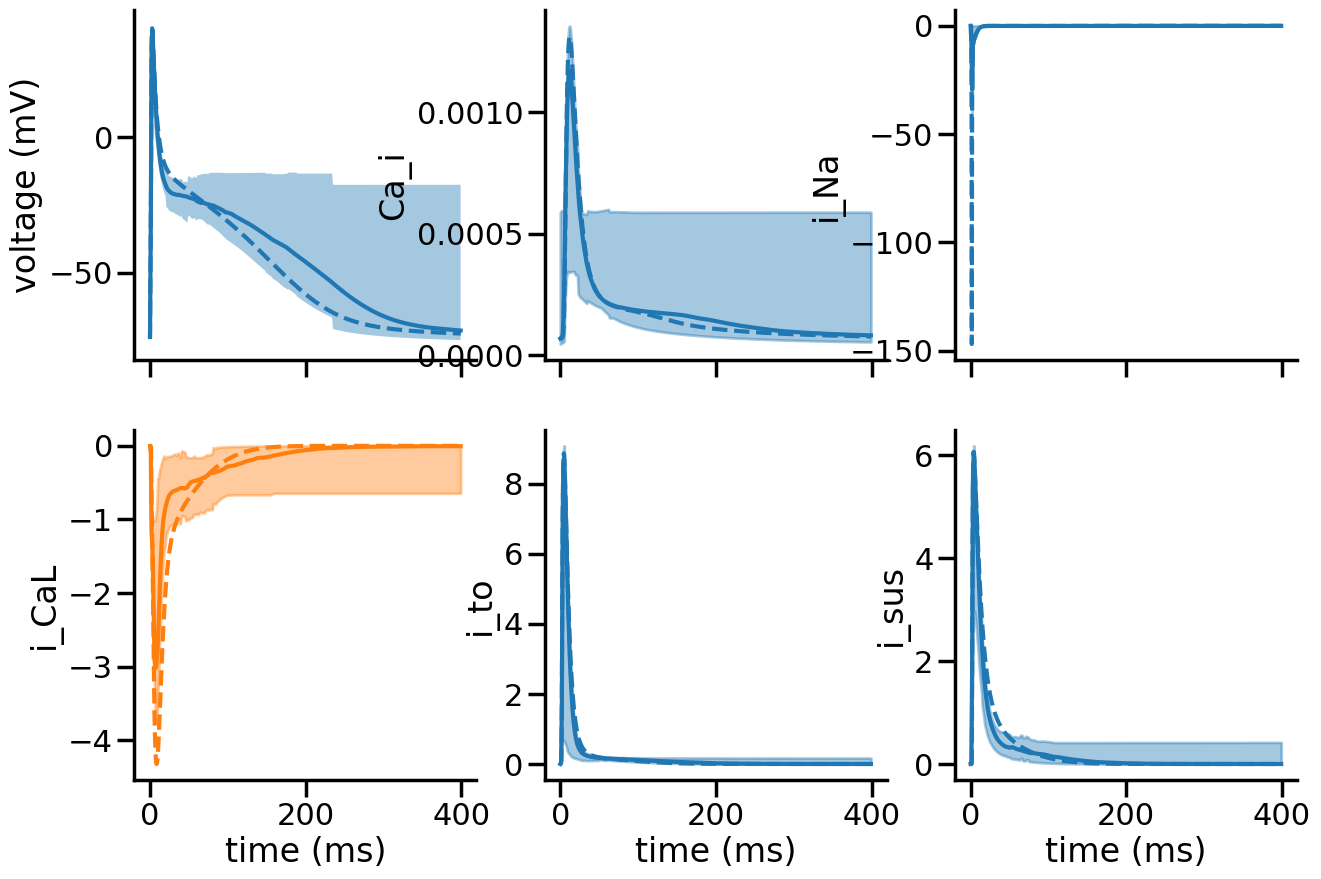

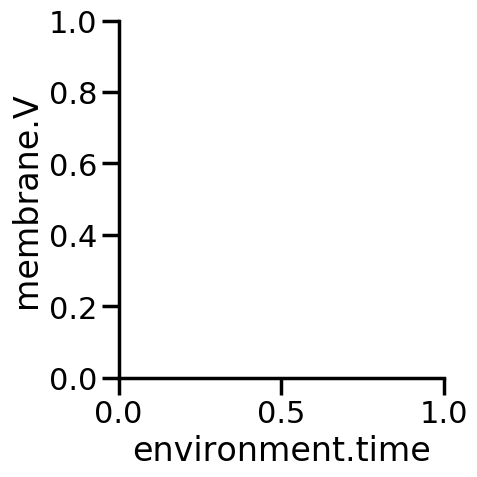

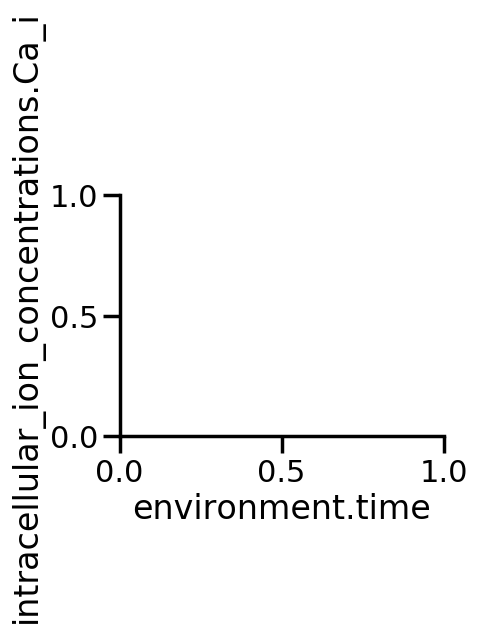

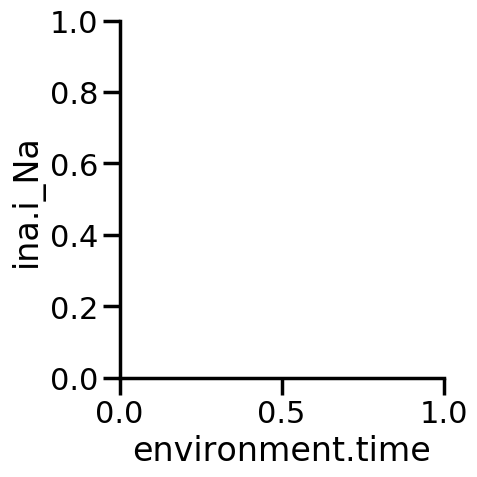

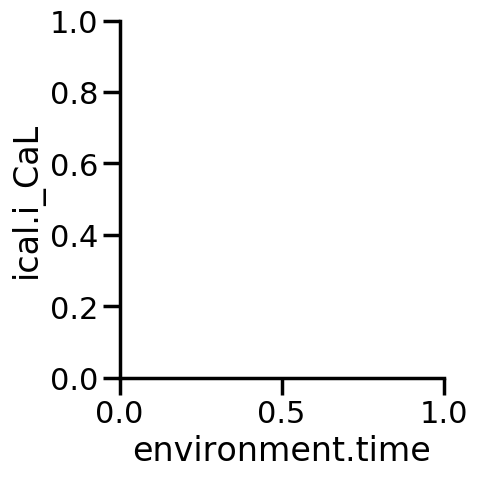

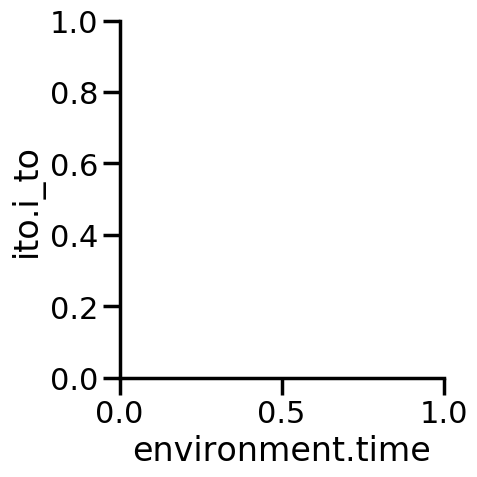

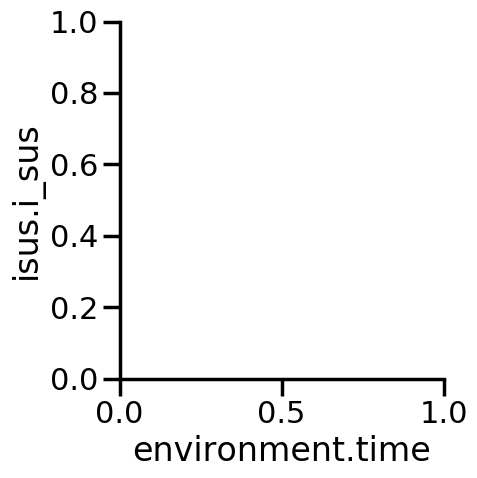

In [1055]:
f = plot_model(nyg_output_ical, data_nyg_original, 
               nyg_log_vars, 
               highlight='ical.i_CaL')
plt.tight_layout()

In [1057]:
#f.savefig('figures/ical/ap_nyg_ical.pdf')

### $I_\mathrm{CaL}$ - COU

In [653]:
# 1 Hz pacing protocol
npulses = 100
period = 1000 # ms
duration = 1 # ms
level = -4000 # pA => -4000/100 = -40 pA/pF
offset = 1e4 # ms

pulsetrain_cou = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = cou.get('membrane.i_st')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

cou_sim = myokit.Simulation(cou, pulsetrain_cou)

In [654]:
# Match peak of i_CaL current during IV experiment

In [655]:
from experiments.ical_li import li_iv_80

In [661]:
_, model, _ = setup('models/courtemanche_ical.mmt',
                    li_iv_80)

In [662]:
original_peak = max(model({})[0]['ical.i_CaL'], key=abs) # from original model

In [663]:
original_peak # pA

-455.20422753888613

In [664]:
h_cou_d_unified = pyabc.History('sqlite:///results/courtemanche/ical/unified/courtemanche_ical_dgate_unified.db')
h_cou_f_unified = pyabc.History('sqlite:///results/courtemanche/ical/unified/courtemanche_ical_fgate_unified.db')

In [665]:
df_cou_d_unified, w_cou_d_unified = h_cou_d_unified.get_distribution(m=0)
df_cou_f_unified, w_cou_f_unified = h_cou_f_unified.get_distribution(m=0)

In [666]:
N = 100
cou_par_samples_d_unified = df_cou_d_unified.sample(n=N, weights=w_cou_d_unified, replace=True)
cou_par_samples_d_unified = cou_par_samples_d_unified.set_index([pd.Index(range(N))])
cou_par_samples_f_unified = df_cou_f_unified.sample(n=N, weights=w_cou_f_unified, replace=True)
cou_par_samples_f_unified = cou_par_samples_f_unified.set_index([pd.Index(range(N))])
cou_samples_ical = (pd.concat([cou_par_samples_d_unified,
                               cou_par_samples_f_unified], axis=1)
                               .to_dict(orient='records'))

In [667]:
peaks = []
for sample in cou_samples_ical:
    peaks.append(max(model(sample)[0]['ical.i_CaL'], key=abs))

In [668]:
cond_factors_cou_ical = [original_peak/p for p in peaks]

In [669]:
print(cond_factors_cou_ical)

[1.6779801856822814, 1.8190738779132234, 1.6622759841239976, 1.7368837526822711, 1.7471519266878095, 1.7270935132158967, 1.8408645707869813, 1.6824535746898557, 1.6314528690617356, 1.8734662785043061, 1.6642773010905436, 1.9061131793084565, 1.789545253907017, 1.720478370087758, 1.8348848997422444, 1.8454290008621173, 1.6985754937846653, 1.7066222569992788, 1.7976925176010021, 1.7540634677403613, 1.9149450483788724, 1.74602182114903, 1.7112298489552402, 1.7675022853779208, 1.7201177650734467, 1.7041309182576194, 1.732646745931836, 1.793811115011709, 1.8390370291034972, 1.7940621931236274, 1.8515421930570337, 1.7727998507107827, 1.8017814929766158, 1.6851927153948691, 1.707437307251877, 1.9044538151725443, 1.8678144422102492, 1.7516961075965491, 1.8246280384362328, 1.8786254607976072, 1.7380879097669382, 1.727297133764788, 1.7173566260351507, 1.7564016151212936, 1.8443019391509408, 1.756765481102983, 1.8183579938503185, 1.960001157288487, 1.8516996868301692, 1.7748758671183076, 1.8564658

In [671]:
cou_output_ical, cou_ap_ical = make_output(cou_sim, pulsetrain_cou, 'C', 'ical', cou_samples_ical,
                                           cond_factors_cou_ical, log_interval=1, ap_offset=400,
                                           log_vars=cou_log_vars)

In [677]:
for var in cou_log_vars:
    if var.split('.')[1][0]=='i':
        cou_output_ical[var] /= Cm_cou

In [672]:
cou_ap_ical.median()

RP       -81.733222
AMP      112.529477
APD90    211.000000
dtype: float64

In [1166]:
calc_hpd(cou_ap_ical)

array([[-81.83539134, -81.597361  ],
       [112.26602968, 112.87093445],
       [189.        , 246.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


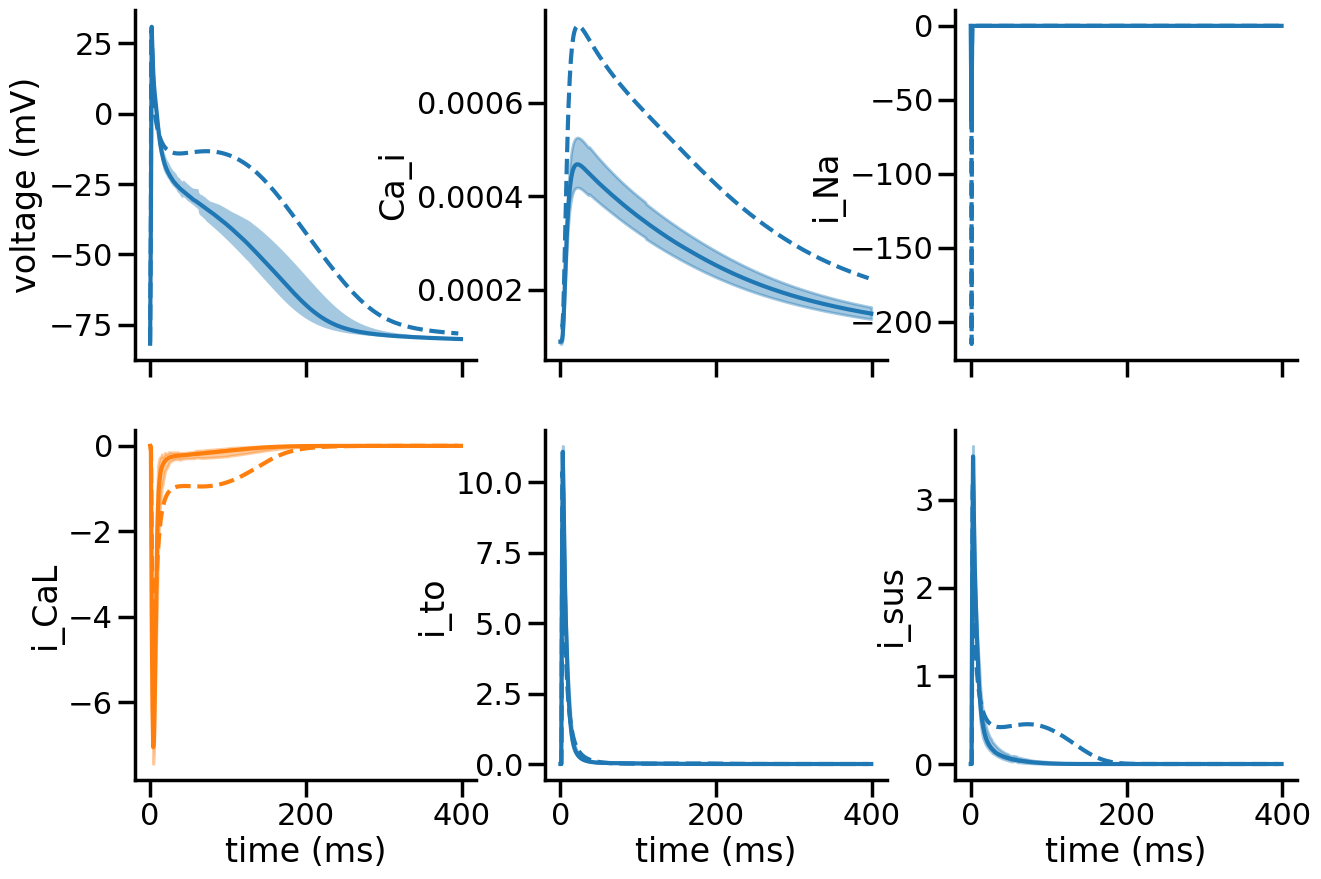

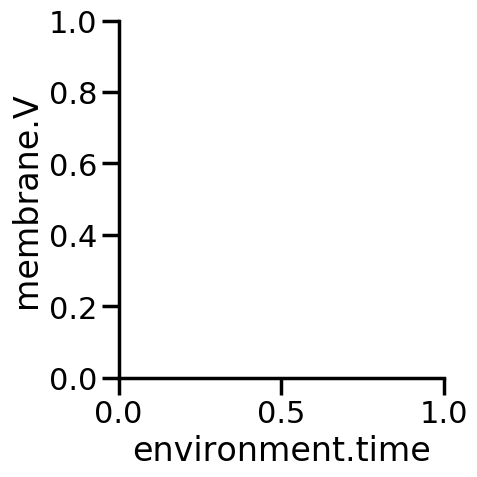

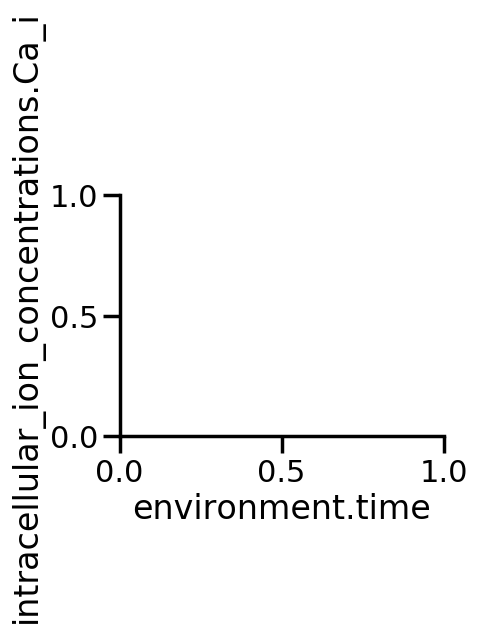

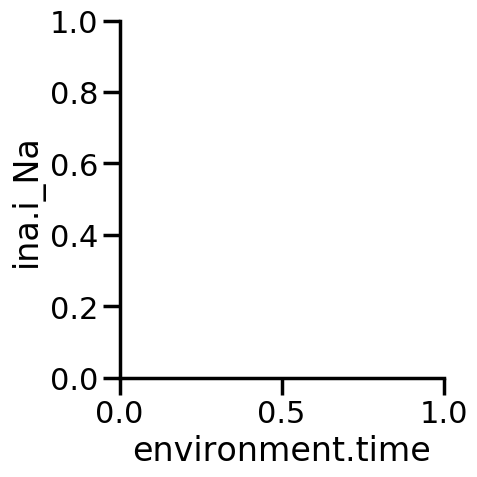

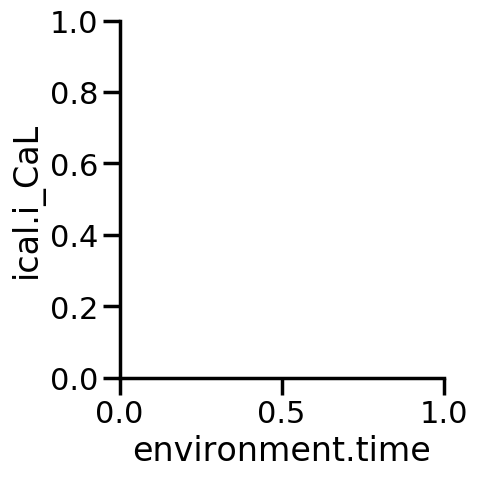

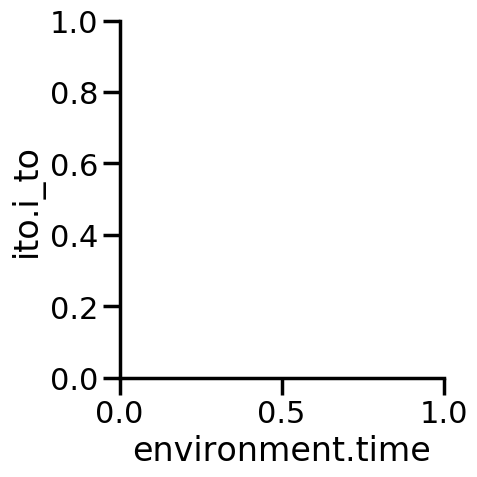

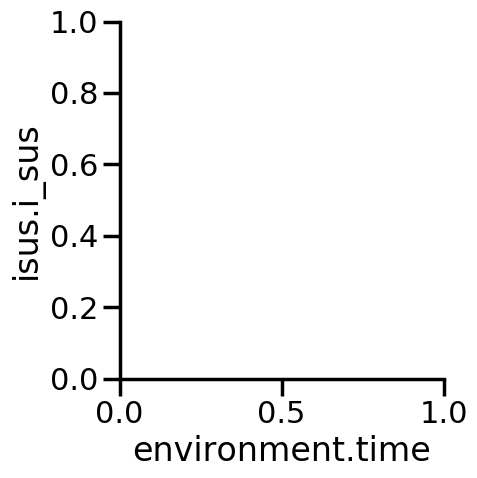

In [1058]:
f = plot_model(cou_output_ical, data_cou_original, cou_log_vars, highlight='ical.i_CaL')
plt.tight_layout()

In [1060]:
#f.savefig('figures/ical/ap_cou_ical.pdf')

### $I_\mathrm{CaL}$ - NYG+S

In [891]:
nyg_ical_sta = myokit.load_model('models/nygren_variability_ical.mmt')

In [892]:
# 1 Hz pacing protocol
npulses = 100
period = 1 # s
duration = 1e-3 # s
level = -2000 # pA -> -2000/50 = -40 pA/pF
offset = 10 # s

pulsetrain_nyg = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = nyg_ical_sta.get('membrane.i_Stim')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
nyg_sim_ical = myokit.Simulation(nyg_ical_sta, pulsetrain_nyg)

In [893]:
# Match peak of i_CaL current during IV experiment

In [894]:
from experiments.ical_li import li_iv_80

In [895]:
observations, model, summary_statistics = setup('models/nygren_ical.mmt',
                                                li_iv_80)

In [896]:
original_peak = max(model({})[0]['ical.i_CaL'], key=abs) # from original model

In [897]:
original_peak

-221.3283838258063

In [898]:
h_sta = pyabc.History('sqlite:///results/standardised/ical/standardised_ical.db')

In [899]:
df_sta, w_sta = h_sta.get_distribution(m=0)

In [900]:
N = 100
sta_samples_ical = df_sta.sample(n=N, weights=w_sta, replace=True)
sta_samples_ical = sta_samples_ical.set_index([pd.Index(range(N))])
sta_samples_ical = sta_samples_ical.to_dict(orient='records')

In [901]:
_, model_sta, _ = setup('models/standardised_ical.mmt',
                        li_iv_80)

In [902]:
peaks = []
for sample in sta_samples_ical:
    peaks.append(max(model_sta(sample)[0]['ical.i_CaL'], key=abs))

In [903]:
cond_factors_nyg_s_ical = [original_peak/p for p in peaks]

In [904]:
print(cond_factors_nyg_s_ical)

[14288.921712698606, 86.70129967648855, 158.53457570117632, 460091655.1909409, 20570.73591945742, 12458.565023904617, 83.97154302207278, 268484899.63009566, 94.33253657887703, 345809123.2143404, 21137.99013685786, 84.0123878886794, 76.06002353010729, 23298.174081241392, 109.35787283152938, 120.67609160654784, 100.22747319842004, 96885757.90573686, 83.40536290506793, 79.03105207128108, 92.81660008080016, 143.4693124680809, 89.92062267125253, 76.53047674072238, 11134862.160002738, 121.60030514006284, 6620454.254681435, 20509.327592355352, 99.34649662729728, 181.76067219458125, 131.16637053114226, 81.14694617448671, 91.84193199474556, 109.58815094138781, 1028.7208450727417, 17170861.524388243, 143.4693124680809, 101.13143249946819, 26528.535952755374, 130.66448613210503, 13756.636548959872, 15142.158314584824, 167.13170190506705, 81.9554613723158, 15037273.15057373, 220278655.09939742, 143.4693124680809, 139831603.1857668, 17632736.252888665, 143.84531047947652, 7206835.791977804, 77.4822

In [905]:
nyg_s_output_ical, nyg_s_ap_ical = make_output(nyg_sim_ical, pulsetrain_nyg, 'N+S', 'ical', sta_samples_ical,
                                               cond_factors_nyg_s_ical, log_interval=0.001, ap_offset=0.4,
                                               log_vars=nyg_log_vars)

In [906]:
nyg_s_output_ical['environment.time'] *= 1e3

In [907]:
for var in nyg_log_vars:
    if var.split('.')[1][0]=='i':
        nyg_s_output_ical[var] /= Cm_nyg

In [908]:
nyg_s_ap_ical['APD90'] = nyg_s_ap_ical['APD90']*1e3

In [909]:
nyg_s_ap_ical.median()

RP       -76.257417
AMP      118.591427
APD90    172.500000
dtype: float64

In [1168]:
calc_hpd(nyg_s_ap_ical)

array([[-76.67323564, -70.34266676],
       [106.08885154, 120.33952458],
       [131.        , 233.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


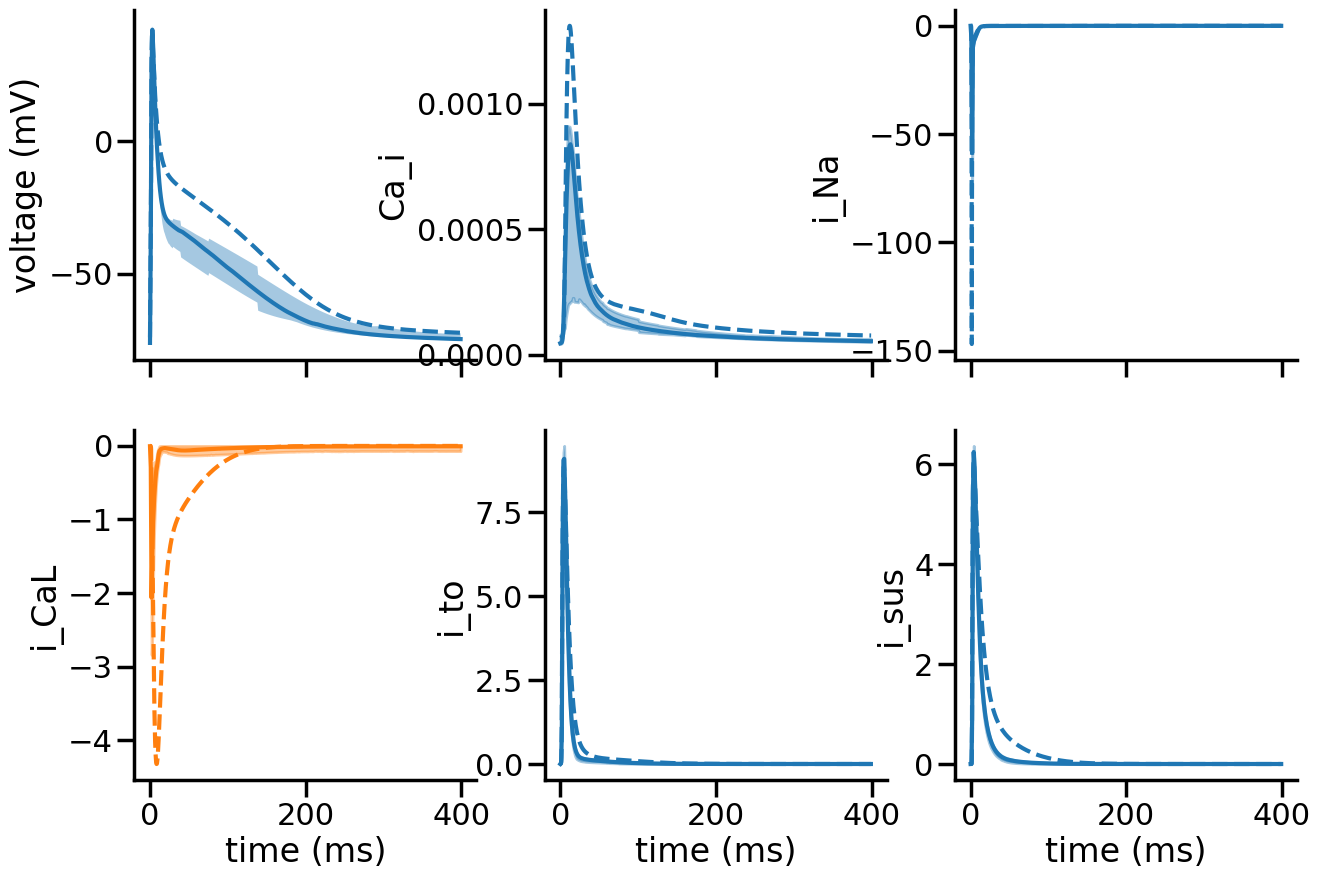

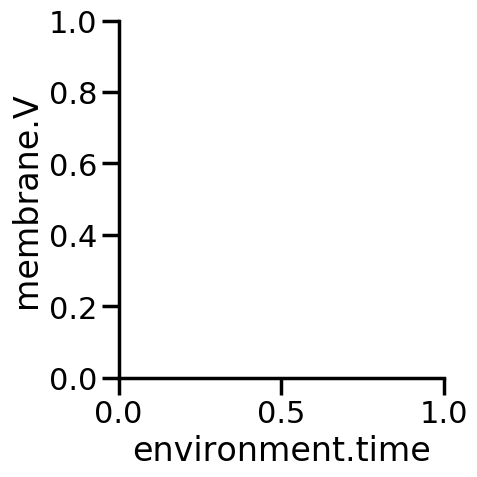

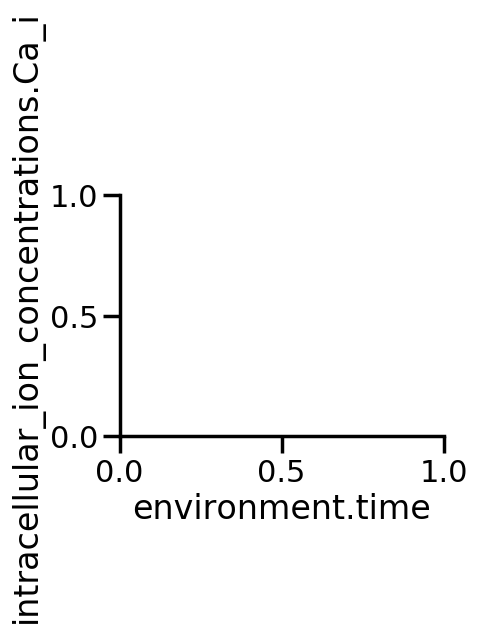

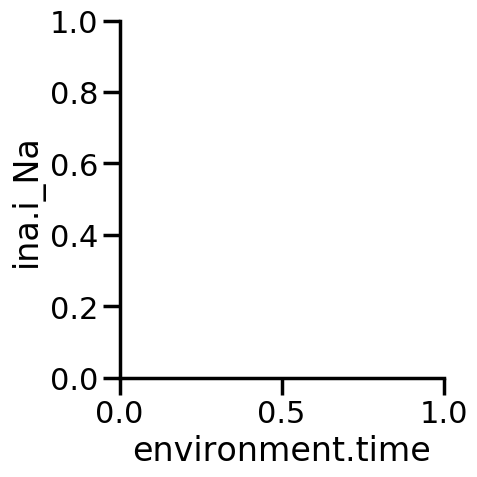

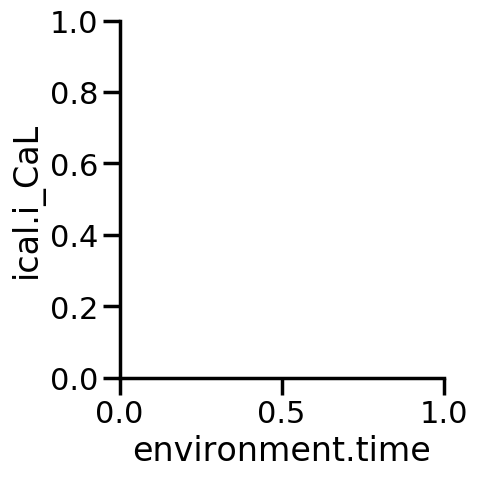

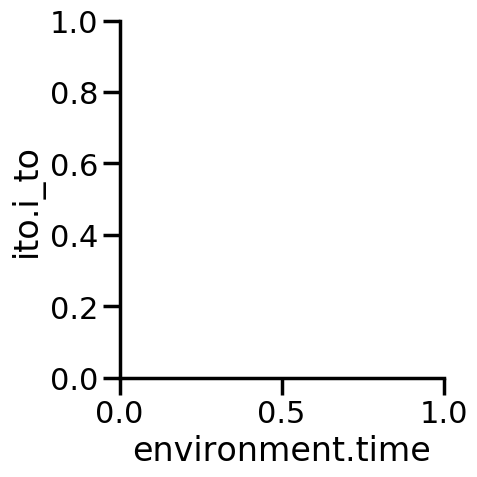

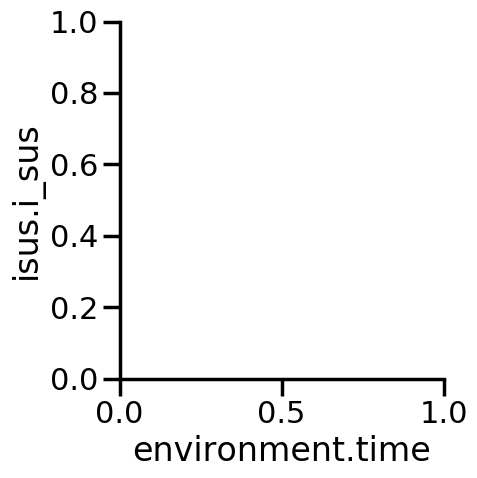

In [1061]:
f = plot_model(nyg_s_output_ical, data_nyg_original, nyg_log_vars, highlight='ical.i_CaL')
plt.tight_layout()

In [1063]:
#f.savefig('figures/ical/ap_nyg_s_ical.pdf')

### $I_\mathrm{CaL}$ - COU+S

In [704]:
cou_ical_sta = myokit.load_model('models/courtemanche_variability_ical.mmt')

In [705]:
# 1 Hz pacing protocol
npulses = 100
period = 1000 # ms
duration = 1 # ms
level = -4000 # pA -> -2000/100 = -40 pA/pF
offset = 1e4 # ms

pulsetrain_cou = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = cou_ical_sta.get('membrane.i_st')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
cou_sim_ical = myokit.Simulation(cou_ical_sta, pulsetrain_cou)

In [706]:
# Match peak of i_CaL current during IV experiment

In [707]:
from experiments.ical_li import li_iv_80

In [709]:
_, model, _ = setup('models/courtemanche_ical.mmt',
                                                li_iv_80)

In [710]:
original_peak = max(model({})[0]['ical.i_CaL'], key=abs) # from original model

In [712]:
original_peak # pA

-455.20422753888613

In [713]:
_, model_sta, _ = setup('models/standardised_ical.mmt',
                                                li_iv_80)

In [714]:
peaks = []
for sample in sta_samples_ical:
    peaks.append(max(model_sta(sample)[0]['ical.i_CaL'], key=abs))

In [715]:
cond_factor_ical = [original_peak/p for p in peaks]

In [716]:
print(cond_factor_ical)

[4530452.592865069, 421.8136175144987, 4018310.2378470832, 2934455.152174189, 2.4819350375505485, 1.7868027758175862, 640077.229924661, 1.5928800005995911, 1.608751274205586, 2.352166776613424, 2.950721296052455, 621043.792943351, 363.04865612323033, 2.1725774956470376, 4.075757962319291, 1.4564935396732017, 1.472419351419488, 6416769.046178161, 1.8533957186048644, 1.548071333955529, 1.6855710886110122, 1.8215058174794925, 1.5643201138115865, 895761.8791125914, 1.8495257858609926, 2.007334064193877, 5609551.051683506, 1.6689424244641269, 19.871560019866845, 1.6689424244641269, 2.046142421741392, 353151.6663736184, 55.07588077012624, 75.15289439631883, 1.7222485690016396, 1.8493898918585319, 1190945.6455003885, 51.6769677699872, 11.649291573765256, 697.6317487770888, 7225203.082567754, 14827.534117034424, 1.5928800005995911, 1.4850454942433955, 2.070598694963054, 2.5925563678643964, 352657.5154061333, 2.2917582085117583, 1.969876470581904, 2.8287113867596823, 4530452.592865069, 1928175.

In [717]:
cou_s_output_ical, cou_s_ap_ical = make_output(cou_sim_ical, pulsetrain_cou, 'C+S', 'ical', sta_samples_ical,
                                               cond_factor_ical, log_interval=1, ap_offset=400,
                                               log_vars=cou_log_vars)

In [719]:
for var in cou_log_vars:
    if var.split('.')[1][0]=='i':
        cou_s_output_ical[var] /= Cm_cou

In [720]:
cou_s_ap_ical.median()

RP       -81.484039
AMP      111.747750
APD90    192.000000
dtype: float64

In [1169]:
calc_hpd(cou_s_ap_ical)

array([[-81.96236372, -27.09108134],
       [ 39.39958467, 112.89569512],
       [ 35.        ,          inf]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


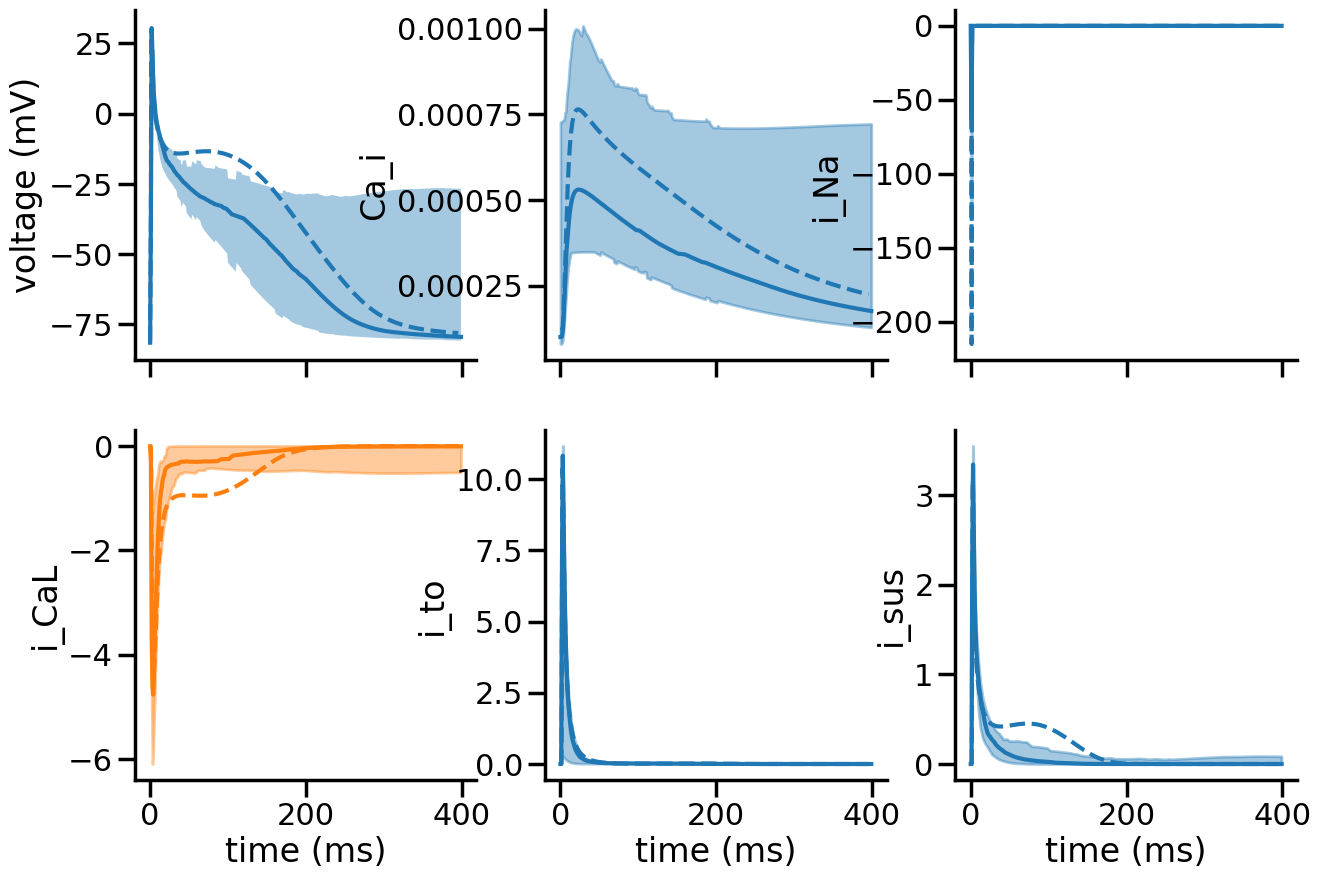

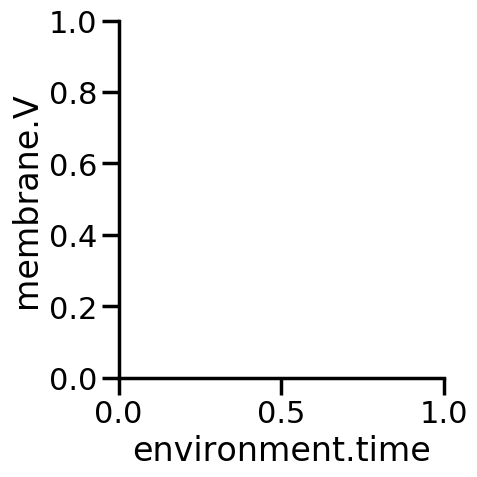

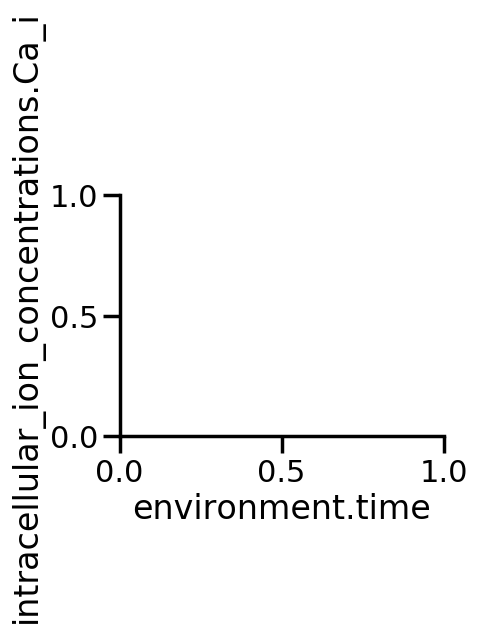

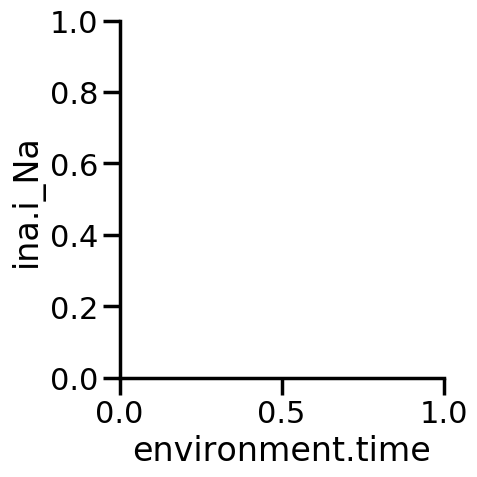

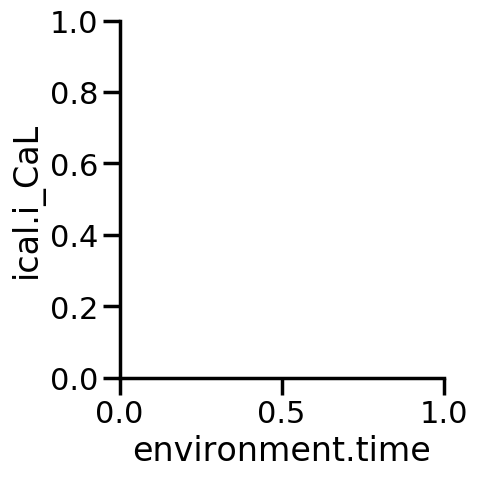

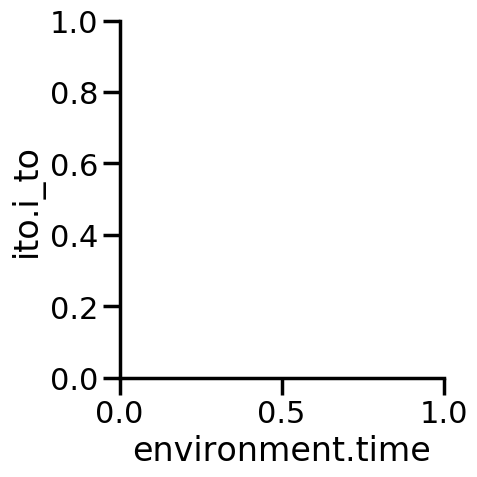

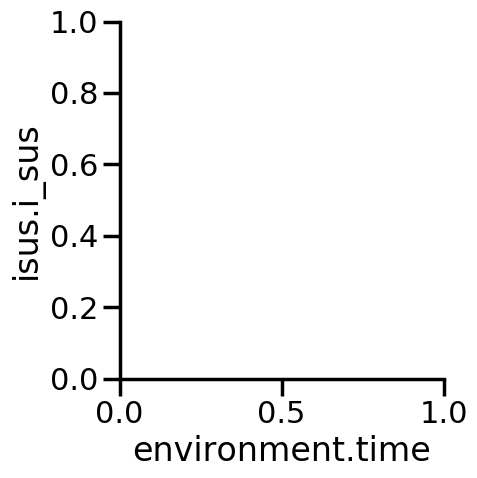

In [1064]:
f = plot_model(cou_s_output_ical, data_cou_original, cou_log_vars, highlight='ical.i_CaL')
plt.tight_layout()

In [1066]:
#f.savefig('figures/ical/ap_cou_s_ical.pdf')

In [913]:
# join the dataframes for each case
ap_ical_df = pd.DataFrame({})
ap_ical_df = ap_ical_df.append([nyg_ap_ical, cou_ap_ical, nyg_s_ap_ical, cou_s_ap_ical])
ap_original_df = pd.DataFrame({})
ap_original_df = ap_original_df.append([nyg_ap_original,
                                        cou_ap_original,
                                        nyg_s_ap_original,
                                        cou_s_ap_original])

In [914]:
ap_original_df

RP         AMP       APD90 model
0 -74.110697  114.301224  223.178334     N
0 -81.172067  110.942165  288.453603     C
0 -74.110697  114.301224  223.178334   N+S
0 -81.172067  110.942165  288.453603   C+S

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


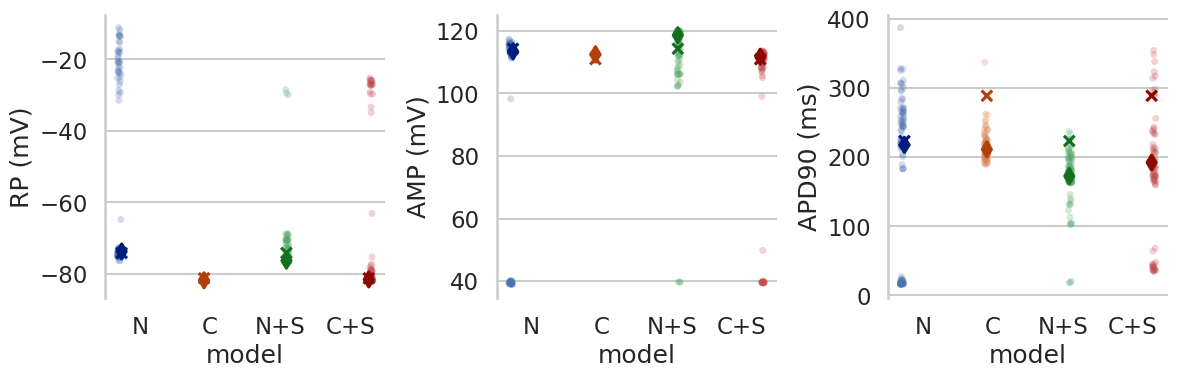

In [915]:
f = plot_ap_measurements(ap_ical_df, ap_original_df)
plt.tight_layout()

In [917]:
#f.savefig('figures/ical/ap_measure_ical.pdf')

In [1112]:
ap_plot_ical = pd.DataFrame({})
models = ['N', 'C']
outputs = [nyg_output_ical, cou_output_ical]
for m, o in zip(models, outputs):
    ap_plot_ical = ap_plot_ical.append(
        pd.DataFrame({'time': o['environment.time'],
                      'V': o['membrane.V'],
                      'model': m})
    )

In [1113]:
ap_plot_ical_s = pd.DataFrame({})
models = ['N+S', 'C+S']
outputs = [nyg_s_output_ical, cou_s_output_ical]
for m, o in zip(models, outputs):
    ap_plot_ical_s = ap_plot_ical_s.append(
        pd.DataFrame({'time': o['environment.time'],
                      'V': o['membrane.V'],
                      'model': m})
    )

In [1128]:
current_palette = sns.color_palette()

In [1135]:
new_pal = current_palette[2:4]

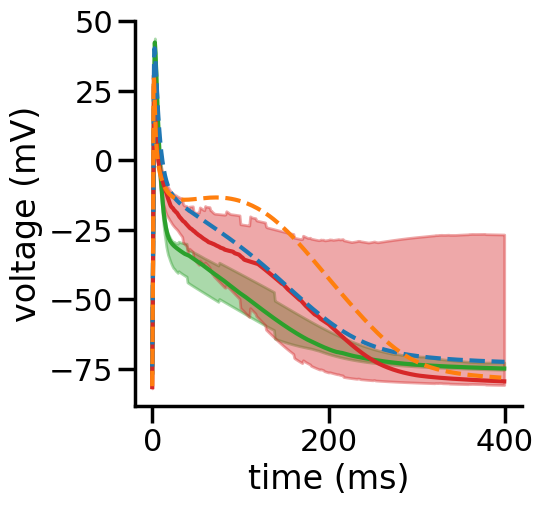

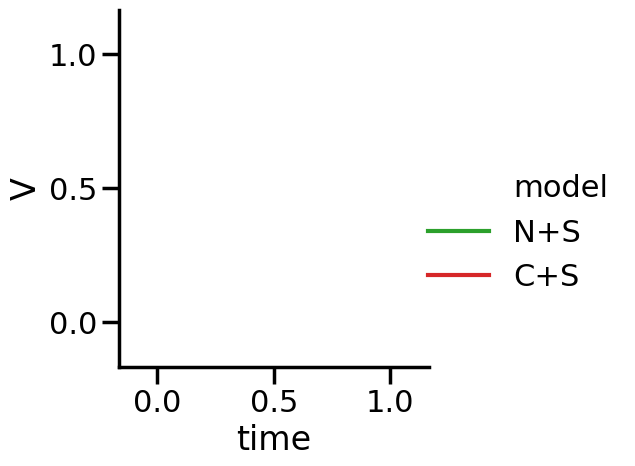

In [1137]:
sns.reset_orig()
sns.set_context('poster')
mpl.rcParams['font.size'] = 14

#data = ap_plot_ical
data = ap_plot_ical_s

fig, ax = plt.subplots(figsize=(5,5))
sns.despine(top=True, right=True)

sns.relplot(x='time', y='V', data=data, hue='model',
            kind='line', estimator=np.median, palette=new_pal,
            ci=None, ax=ax)
for m in data['model'].unique():
    data_m = data[data['model']==m]
    hpd = np.zeros((len(data_m['time'].unique()), 2))
    for j, tj in enumerate(data_m['time'].unique()):
        data_tj = data_m[(data_m['time']==tj)]
        hpd[j,:] = pymc3.hpd(data_tj['V'], credible_interval=0.89)
    color='C0'
    if m=='N':
        color='C0'
    elif m=='C':
        color='C1'
    elif m=='N+S':
        color='C2'
    elif m=='C+S':
        color='C3'
    ax.fill_between(data_m['time'].unique(), hpd[:,0], hpd[:,1], alpha=0.4, color=color)
    if m=='N' or m=='N+S':
        ax.plot(data_nyg_original['environment.time'],
               data_nyg_original['membrane.V'],
               linestyle='--', color='C0')
    elif m=='C' or m=='C+S':
        ax.plot(data_cou_original['environment.time'],
           data_cou_original['membrane.V'],
           linestyle='--', color='C1')
    #g.axes[0].plot(original['time'], original['V'], linestyle='--')
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('voltage (mV)')


In [1139]:
#fig.savefig('figures/ical/ap_ical_NandC_s.pdf')

### $I_\mathrm{to}$ - NYG

In [732]:
# need to refresh nyg_sim
npulses = 100
period = 1 # s
duration = 1e-3 # s
level = -2000 # pA -> -2000/50 = -40 pA/pF
offset = 10 # s

pulsetrain_nyg = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = nyg.get('membrane.i_Stim')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
nyg_sim = myokit.Simulation(nyg, pulsetrain_nyg)

In [733]:
# Match peak of i_to current at step to 60mV

In [734]:
protocol_ito = myokit.pacing.steptrain([60], -50, 10000, 1000)

In [735]:
nyg_model_ito = myokit.load_model('models/nygren_ito.mmt')

In [736]:
pace = nyg_model_ito.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [737]:
nyg_sim_ito = myokit.Simulation(nyg_model_ito, protocol_ito)

In [738]:
data_nyg_ito = nyg_sim_ito.run(protocol_ito.characteristic_time())

In [739]:
original_peak = max(data_nyg_ito['ito.i_to'], key=abs)

In [741]:
print(original_peak) # pA

521.5697228631749


In [742]:
# test with samples from posterior
h_nyg_unified = pyabc.History('sqlite:///results/nygren/ito/unified/nygren_ito_unified.db')
df_nyg_unified, w_nyg_unified = h_nyg_unified.get_distribution(m=0)

In [743]:
N = 100
nyg_samples_ito = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_samples_ito = nyg_samples_ito.set_index([pd.Index(range(N))])
nyg_samples_ito = nyg_samples_ito.to_dict(orient='records')

In [744]:
peaks = []
for i, sample in enumerate(nyg_samples_ito):
    nyg_sim_ito.reset()
    for p, v in sample.items():
        name = p
        value = v
        if p.startswith("log"):
            name = p[4:]
            value = 10**v
        nyg_sim_ito.set_constant(name, value)
        
    temp_data = nyg_sim_ito.run(protocol_ito.characteristic_time())
    peaks.append(max(temp_data['ito.i_to'], key=abs))

In [745]:
# multiplier to ensure same over conductance
cond_factors_nyg_ito = [original_peak/p for p in peaks]

In [746]:
print(cond_factors_nyg_ito)

[0.9494400288736067, 0.9618140317352155, 0.9616416887447292, 0.9573914899158338, 0.9494400288736067, 0.9601214609443897, 0.9641394166811605, 0.9500240711149331, 0.937011813667455, 0.9551868413943875, 0.9716684413557852, 0.9569929263630559, 0.9513825842504914, 0.9549118705643636, 0.96510669998941, 0.9781430523056, 0.9758995351927422, 0.9455410445660726, 0.9450230840441366, 0.9561514592288715, 0.9489026859709392, 0.9737382786605033, 0.9581247243310262, 0.9447948979875539, 0.9680856620044858, 0.963993919232859, 0.950036502439726, 0.959633706233794, 0.9600889416946042, 0.9549600742310219, 0.9384311721730185, 0.9584807083837656, 0.9263708553435436, 0.9558020434555101, 0.9327868962144854, 0.9611039225603638, 0.9670702032256858, 0.944359880127373, 0.9480862249248904, 0.9582560414250348, 0.9670610591227141, 0.9549054874451304, 0.9561539783242391, 0.9404387977311196, 0.9491704694489619, 0.9741302161747988, 0.9653471002975961, 0.942993017467987, 0.9670702032256858, 0.9635874322103279, 0.96346761

In [747]:
nyg_output_ito, nyg_ap_ito = make_output(nyg_sim, pulsetrain_nyg, 'N', 'ito', nyg_samples_ito,
                                         cond_factors_nyg_ito, log_interval=0.001, ap_offset=0.4,
                                         log_vars=nyg_log_vars)

In [748]:
nyg_output_ito['environment.time'] *= 1e3

In [749]:
for var in nyg_log_vars:
    if var.split('.')[1][0]=='i':
        nyg_output_ito[var] /= Cm_nyg

In [750]:
nyg_ap_ito['APD90'] *= 1e3

In [751]:
nyg_ap_ito.median()

RP       -72.687935
AMP      113.379443
APD90    271.000000
dtype: float64

In [1170]:
calc_hpd(nyg_ap_ito)

array([[-72.74942705, -72.51824537],
       [113.11005874, 113.58787329],
       [266.        , 280.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


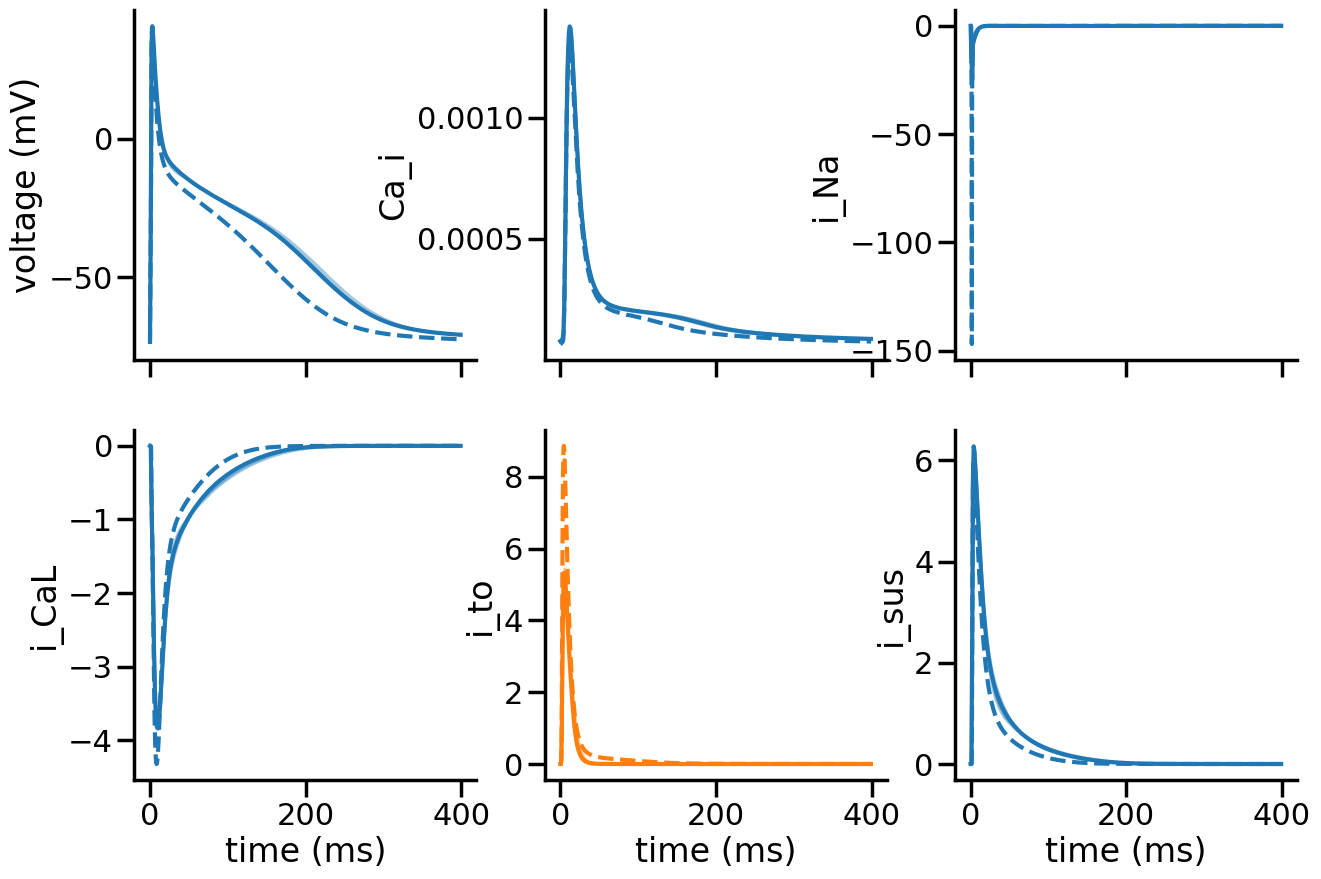

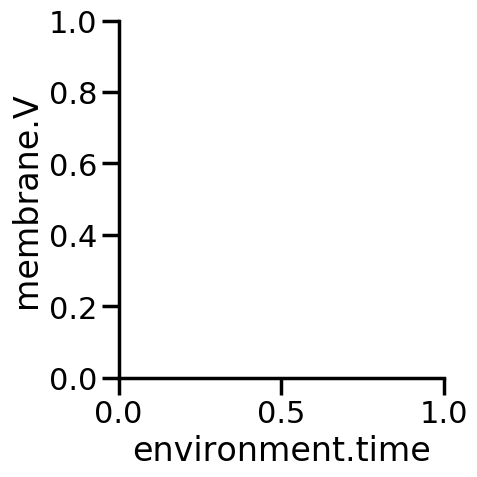

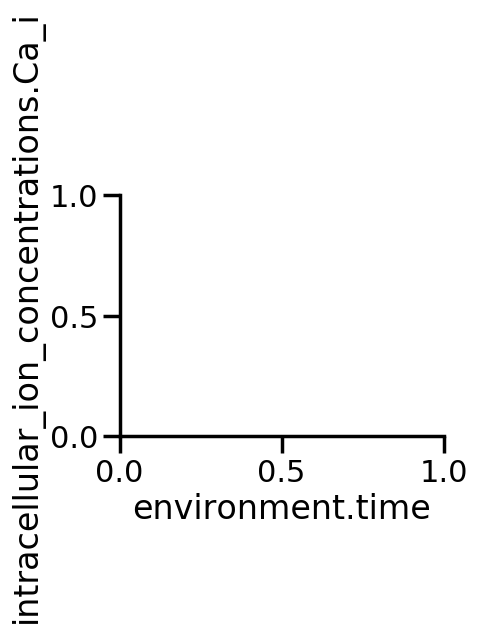

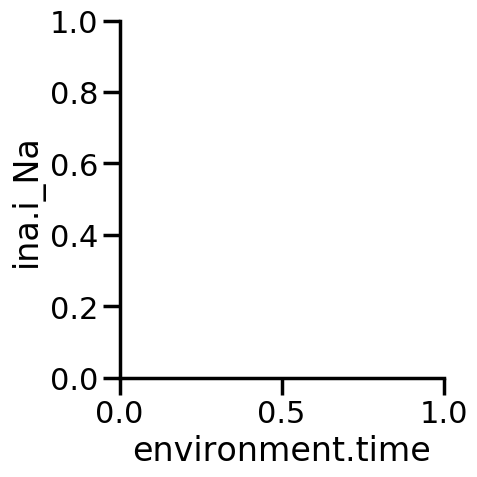

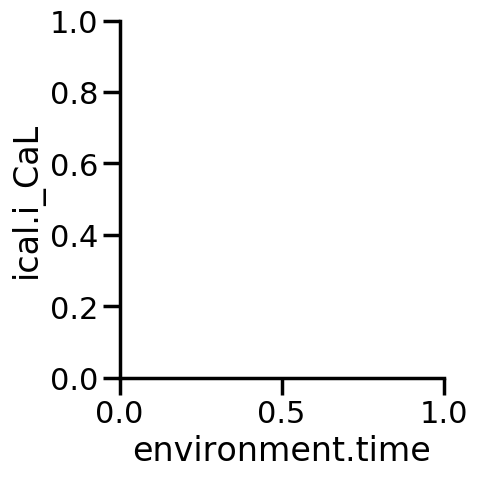

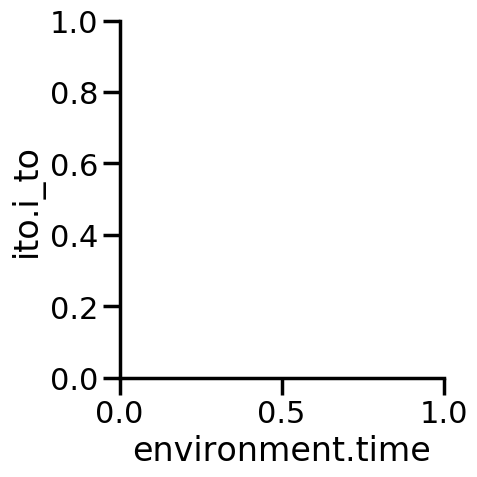

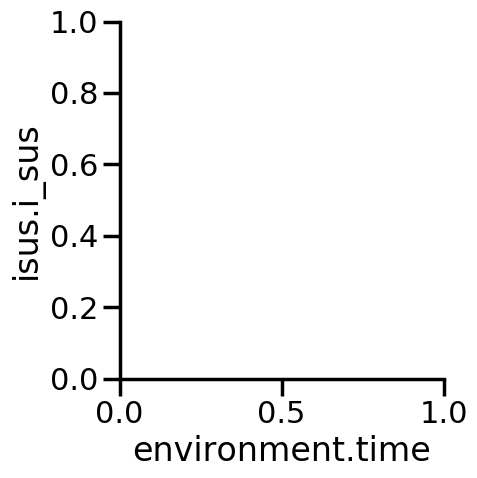

In [1067]:
f = plot_model(nyg_output_ito, data_nyg_original, nyg_log_vars, highlight='ito.i_to')
plt.tight_layout()

In [1069]:
#f.savefig('figures/ito/ap_nyg_ito.pdf')

### $I_\mathrm{to}$ - COU

In [762]:
# need to refresh cou_sim
npulses = 100
period = 1000 # ms
duration = 1 # ms
level = -4000 # pA -> -4000/100 = -40 pA/pF
offset = 1e4 # ms

pulsetrain_cou = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = cou.get('membrane.i_st')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
cou_sim = myokit.Simulation(cou, pulsetrain_cou)

In [763]:
# Match peak of i_to current at step to 60mV

In [764]:
protocol_ito = myokit.pacing.steptrain([60], -50, 10000, 1000)

In [765]:
cou_model_ito = myokit.load_model('models/courtemanche_ito.mmt')

In [766]:
pace = cou_model_ito.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [767]:
cou_sim_ito = myokit.Simulation(cou_model_ito, protocol_ito)

In [768]:
data_cou_ito = cou_sim_ito.run(protocol_ito.characteristic_time())

In [769]:
original_peak = max(data_cou_ito['ito.i_to'], key=abs)

In [771]:
print(original_peak) # pA

1535.2117366420093


In [772]:
# COU uses same original and unified datasets
h_cou_a_original = pyabc.History('sqlite:///results/courtemanche/ito/original/courtemanche_ito_agate_original.db')
h_cou_i_original = pyabc.History('sqlite:///results/courtemanche/ito/original/courtemanche_ito_igate_original.db')

In [773]:
df_cou_a_original, w_cou_a_original = h_cou_a_original.get_distribution(m=0)
df_cou_i_original, w_cou_i_original = h_cou_i_original.get_distribution(m=0)

In [774]:
N = 100
cou_par_samples_a_original = df_cou_a_original.sample(n=N, weights=w_cou_a_original, replace=True)
cou_par_samples_a_original = cou_par_samples_a_original.set_index([pd.Index(range(N))])
cou_par_samples_i_original = df_cou_i_original.sample(n=N, weights=w_cou_i_original, replace=True)
cou_par_samples_i_original = cou_par_samples_i_original.set_index([pd.Index(range(N))])
cou_samples_ito = (pd.concat([cou_par_samples_a_original,
                              cou_par_samples_i_original],axis=1)
                   .to_dict(orient='records'))

In [775]:
peaks = []
for i, sample in enumerate(cou_samples_ito):
    cou_sim_ito.reset()
    for p, v in sample.items():
        name = p
        value = v
        if p.startswith("log"):
            name = p[4:]
            value = 10**v
        cou_sim_ito.set_constant(name, value)
        
    temp_data = cou_sim_ito.run(protocol_ito.characteristic_time())
    peaks.append(max(temp_data['ito.i_to'], key=abs))

In [776]:
# multiplier to ensure same over conductance
cond_factors_cou_ito = [original_peak/p for p in peaks]

In [777]:
print(cond_factors_cou_ito)

[0.7902164024623438, 0.912026837479087, 0.9284603608707735, 0.8071295479478173, 0.7893120313811497, 0.7693256550817478, 0.7251515512442838, 0.7798918218907731, 0.811848329286471, 0.7329402396715137, 0.8422710624754121, 0.8644021923663538, 0.7940474919633781, 0.7829845609528066, 0.8006379510347597, 0.8741901834718993, 0.8342875410886199, 0.8876695540839696, 0.8433079559910416, 0.7344470801837304, 0.7402892360153492, 0.908834556467977, 0.7947082207874064, 0.8839100123522754, 0.7669489379607896, 0.8157546362255972, 0.7921917663117038, 0.8662099379916083, 0.8963471971475209, 0.8756114195241371, 0.7669036484058865, 0.7131203761734279, 0.776187232347293, 0.7752159327154113, 0.7922804485723469, 0.811326645277393, 0.8075457728093335, 0.8647661066633416, 0.7972001233167544, 0.874862637719725, 0.7943229519781202, 0.86152908133892, 0.7557805823679367, 0.8751304603518758, 0.8434794477038988, 0.8382503419676212, 0.7960397424079984, 0.8232613427430056, 0.7763179225401701, 0.8178368893167839, 0.82293

In [779]:
cou_output_ito, cou_ap_ito = make_output(cou_sim, pulsetrain_cou, 'C', 'ito', cou_samples_ito,
                                         cond_factors_cou_ito, log_interval=1, ap_offset=400,
                                         log_vars=cou_log_vars)

In [780]:
for var in cou_log_vars:
    if var.split('.')[1][0]=='i':
        cou_output_ito[var] /= Cm_cou

In [781]:
cou_ap_ito.median()

RP       -81.273442
AMP      109.427323
APD90    257.000000
dtype: float64

In [1171]:
calc_hpd(cou_ap_ito)

array([[-81.35666227, -81.21541177],
       [107.47231013, 110.94414241],
       [247.        , 266.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


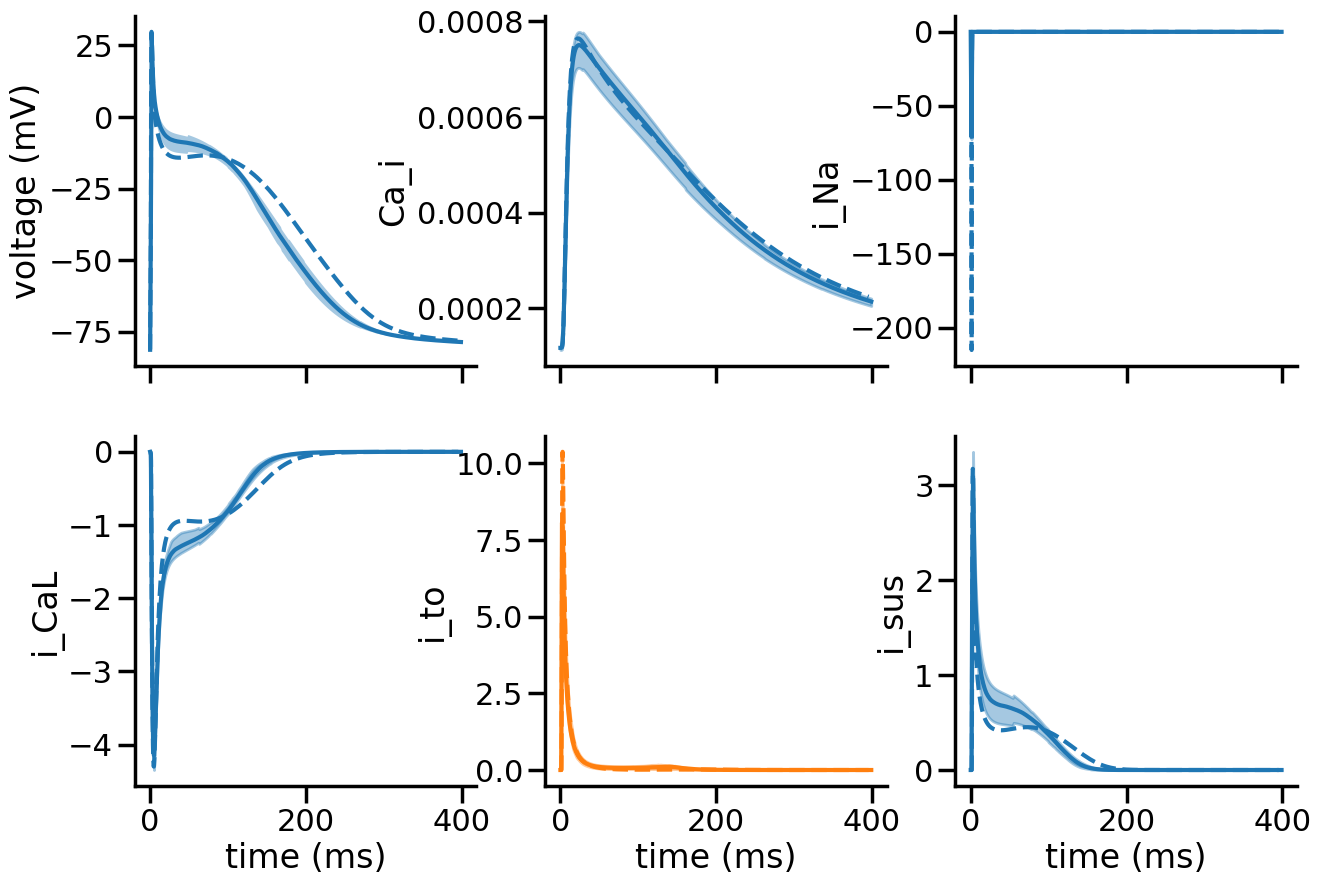

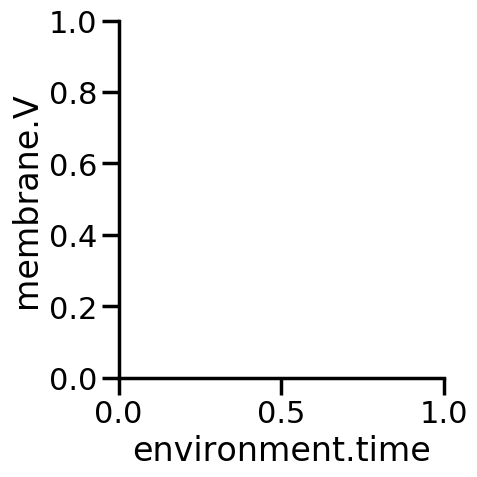

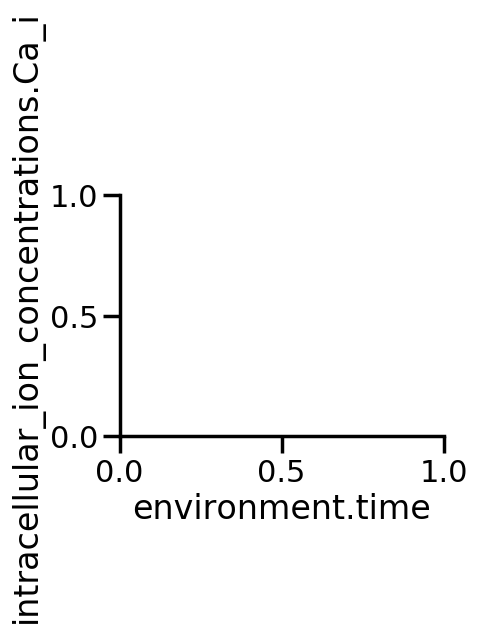

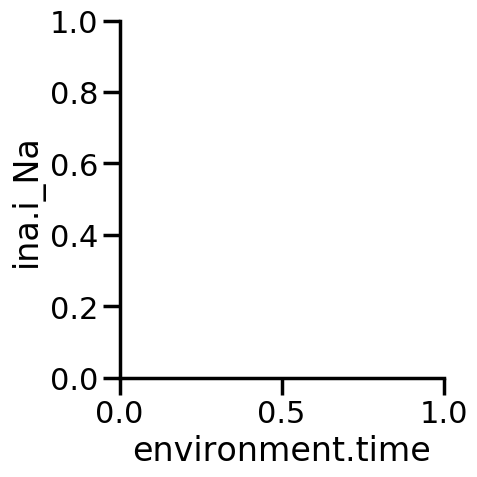

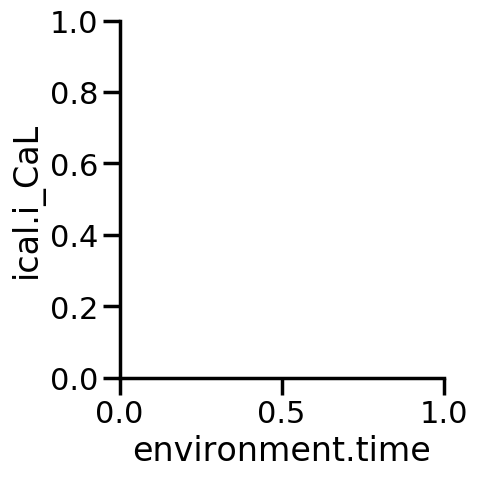

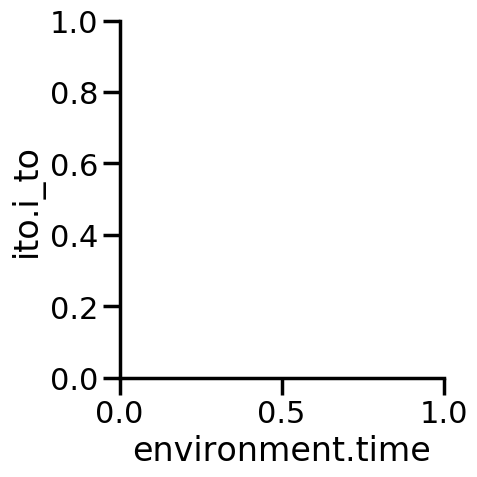

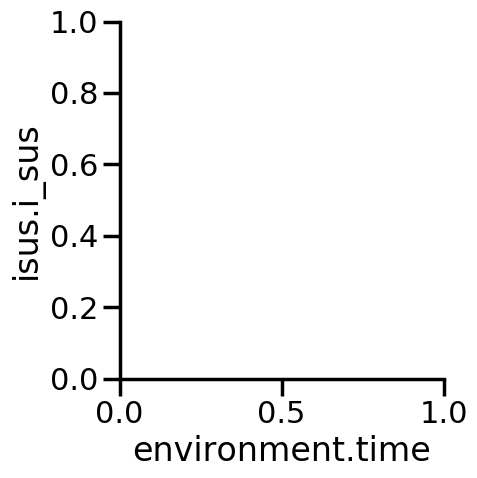

In [1070]:
f = plot_model(cou_output_ito, data_cou_original, cou_log_vars, highlight='ito.i_to')
plt.tight_layout()

In [1072]:
#f.savefig('figures/ito/ap_cou_ito.pdf')

### $I_\mathrm{to}$ - NYG+S

In [814]:
nyg_s_ito = myokit.load_model('models/nygren_variability_ito.mmt')

In [815]:
# 1 Hz pacing protocol
npulses = 100
period = 1 # s
duration = 1e-3 # s
level = -2000 # pA -> -2000/50 = -40 pA/pF
offset = 10 # s

pulsetrain_nyg = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = nyg_s_ito.get('membrane.i_Stim')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
nyg_s_ito_sim = myokit.Simulation(nyg_s_ito, pulsetrain_nyg)

In [816]:
# Match peak of i_to current at step to 60mV

In [817]:
protocol_ito = myokit.pacing.steptrain([60], -50, 10000, 1000)

In [818]:
nyg_model_ito = myokit.load_model('models/nygren_ito.mmt')

In [819]:
pace = nyg_model_ito.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [820]:
nyg_sim_ito = myokit.Simulation(nyg_model_ito, protocol_ito)

In [821]:
data_nyg_ito = nyg_sim_ito.run(protocol_ito.characteristic_time())

In [822]:
original_peak = max(data_nyg_ito['ito.i_to'], key=abs)

In [823]:
print(original_peak) # pA

521.5697228631749


In [1036]:
# test with samples from posterior
h_sta = pyabc.History('sqlite:///results/standardised/ito/standardised_ito.db')
df_sta, w_sta = h_sta.get_distribution(m=0)

In [1037]:
N = 100
sta_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
sta_samples = sta_samples.set_index([pd.Index(range(N))])
sta_samples = sta_samples.to_dict(orient='records')

In [826]:
sta_model = myokit.load_model('models/standardised_ito_nyg_temp.mmt')

pace = sta_model.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

sta_sim_ito = myokit.Simulation(sta_model, protocol_ito)

In [827]:
peaks = []
for i, sample in enumerate(sta_samples):
    sta_sim_ito.reset()
    for p, v in sample.items():
        name = p
        value = v
        if p.startswith("log"):
            name = p[4:]
            value = 10**v
        sta_sim_ito.set_constant(name, value)
        
    temp_data = sta_sim_ito.run(protocol_ito.characteristic_time())
    peaks.append(max(temp_data['ito.i_to'], key=abs))

In [828]:
# multiplier to ensure same over conductance
cond_factors_nyg_s_ito = [original_peak/p for p in peaks]

In [829]:
print(cond_factors_nyg_s_ito)

[391.85347972307005, 370.6975594390552, 390.81841232360836, 404.33320251806765, 421.497728348944, 382.5173037507132, 401.17816340651825, 381.07177663018655, 393.6066317766675, 420.4904935935798, 424.05995652690984, 395.36884614588286, 389.5942982004659, 378.0638767247261, 382.0584382297151, 401.53531667041335, 387.2875870395978, 370.77319128500045, 401.17816340651825, 407.2379222183984, 397.1216195196379, 402.8424139444975, 410.6608069614716, 397.5502905968933, 375.05907583904997, 384.4861607289608, 384.4861607289608, 375.05907583904997, 394.56817623021146, 386.6219725911858, 407.0428089463132, 411.0207423243927, 414.85734625909794, 409.10784122820434, 387.80962687957737, 414.0150307360788, 416.95721044920185, 381.07177663018655, 408.5827729861732, 374.5696499068897, 410.97675221395826, 408.12796215977477, 419.5895838089913, 394.5577820797569, 495.84325002186375, 391.2540339488566, 393.2953543097124, 402.7306563021032, 408.12796215977477, 380.09902244805176, 395.60758390944693, 405.283

In [830]:
nyg_s_output_ito, nyg_s_ap_ito = make_output(nyg_s_ito_sim, pulsetrain_nyg, 'N+S', 'ito', sta_samples,
                                             cond_factors_nyg_s_ito, log_interval=0.001, ap_offset=0.4,
                                             log_vars=nyg_log_vars)

In [831]:
nyg_s_output_ito['environment.time'] *= 1e3

In [832]:
for var in nyg_log_vars:
    if var.split('.')[1][0]=='i':
        nyg_s_output_ito[var] /= Cm_nyg

In [833]:
nyg_s_ap_ito['APD90'] *= 1e3

In [834]:
nyg_s_ap_ito.median()

RP       -73.166745
AMP      110.753345
APD90    248.000000
dtype: float64

In [1172]:
calc_hpd(nyg_s_ap_ito)

array([[-73.22998167, -73.14832355],
       [110.5986151 , 110.9739885 ],
       [245.        , 249.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


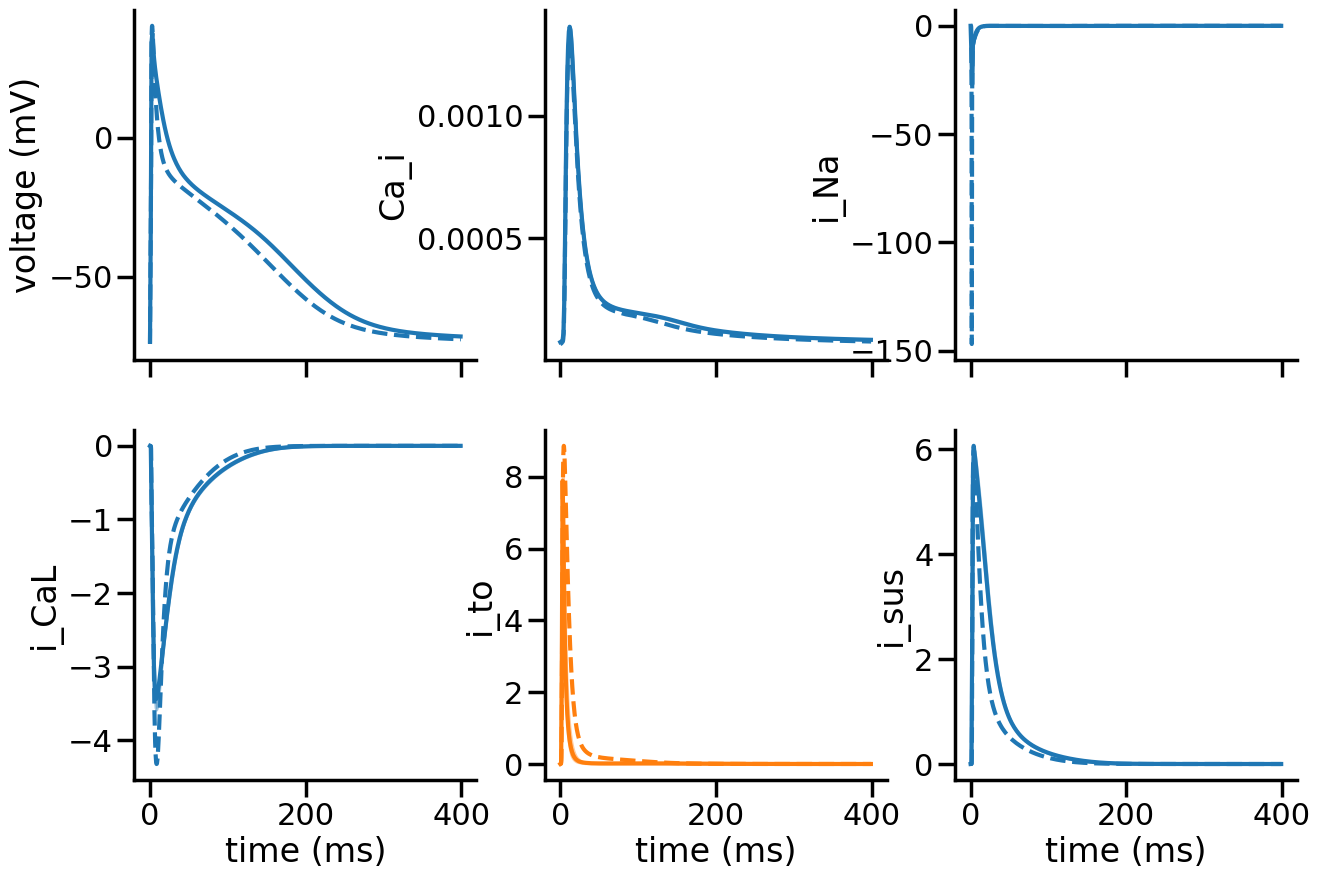

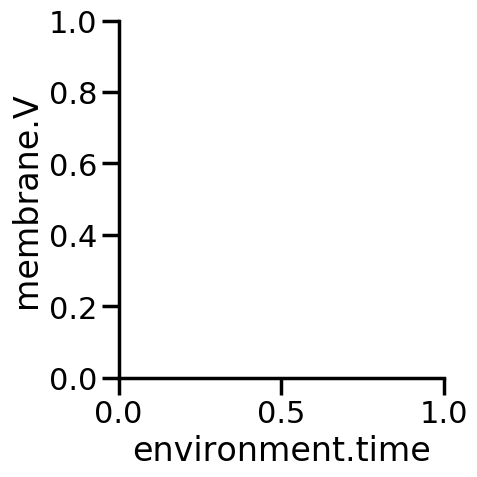

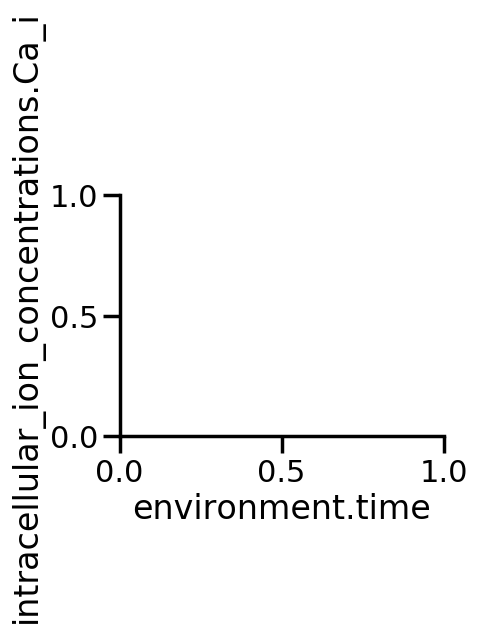

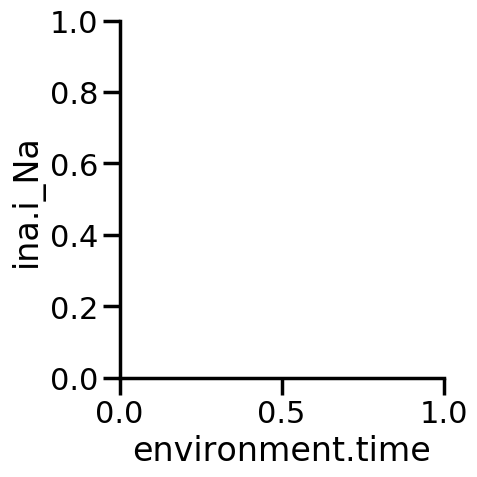

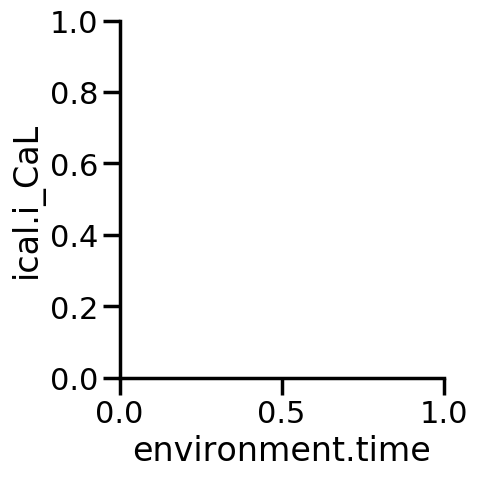

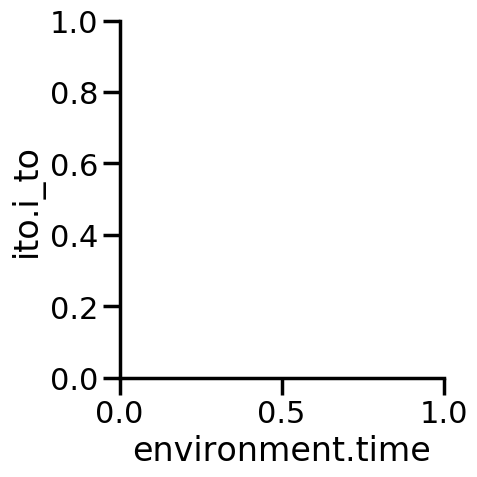

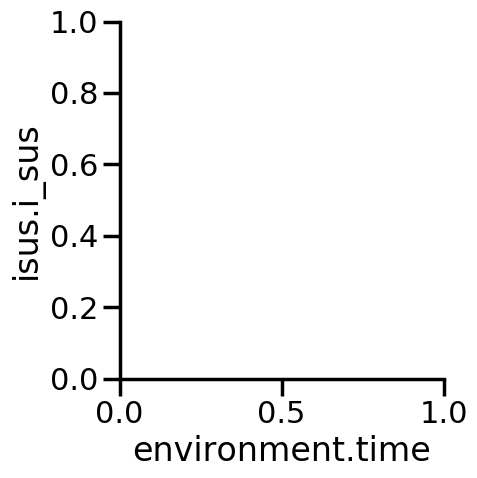

In [1073]:
f = plot_model(nyg_s_output_ito, data_nyg_original, nyg_log_vars, highlight='ito.i_to')
plt.tight_layout()

In [1075]:
#f.savefig('figures/ito/ap_nyg_s_ito.pdf')

### $I_\mathrm{to}$ - COU+S

In [1024]:
cou_s_ito = myokit.load_model('models/courtemanche_variability_ito.mmt')

In [1025]:
# 1 Hz pacing protocol
npulses = 100
period = 1000 # ms
duration = 1 # ms
level = -4000 # pA -> -4000/100 = -40 pA/pF
offset = 1e4 # ms

pulsetrain_cou = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = cou_s_ito.get('membrane.i_st')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
cou_s_ito_sim = myokit.Simulation(cou_s_ito, pulsetrain_cou)

In [1026]:
# Match peak of i_to current at step to 60mV

In [1027]:
protocol_ito = myokit.pacing.steptrain([60], -50, 10000, 1000)

In [1028]:
cou_model_ito = myokit.load_model('models/courtemanche_ito_sta_temp.mmt')

In [1029]:
pace = cou_model_ito.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [1030]:
cou_sim_ito = myokit.Simulation(cou_model_ito, protocol_ito)

In [1031]:
data_cou_ito = cou_sim_ito.run(protocol_ito.characteristic_time())

In [1032]:
original_peak = max(data_cou_ito['ito.i_to'], key=abs)

In [1033]:
print(original_peak) #pA/pF

15.795646685577656


In [1034]:
sta_model = myokit.load_model('models/standardised_ito.mmt')

pace = sta_model.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

sta_sim_ito = myokit.Simulation(sta_model, protocol_ito)

In [1038]:
peaks = []
for i, sample in enumerate(sta_samples):
    sta_sim_ito.reset()
    for p, v in sample.items():
        name = p
        value = v
        if p.startswith("log"):
            name = p[4:]
            value = 10**v
        sta_sim_ito.set_constant(name, value)
        
    temp_data = sta_sim_ito.run(protocol_ito.characteristic_time())
    peaks.append(max(temp_data['ito.i_to'], key=abs))

In [1039]:
# multiplier to ensure same over conductance
cond_factors_cou_s_ito = [original_peak/p for p in peaks]

In [1040]:
print(cond_factors_cou_s_ito)

[22.888392448173565, 21.17057995369397, 20.52996666529481, 20.46510031049438, 23.356356319546236, 22.044292900618295, 20.46510031049438, 21.667007185512304, 22.44410395761983, 22.048603342788024, 22.114615698336824, 21.146145401936547, 21.146145401936547, 22.645522686169123, 22.57020489510149, 23.335650627107345, 22.63862536801937, 23.63196552472501, 28.079125553794448, 23.259820259861954, 22.114615698336824, 22.027061285293794, 21.897960860614614, 22.295601300814692, 23.80288454068616, 21.677004298120192, 21.8203859110563, 21.593630398512254, 23.69955416649646, 21.746017535762622, 22.450795826444946, 22.265019613527343, 20.368896011057437, 20.920549769748387, 21.86664289158518, 20.741476476818814, 21.149205592673635, 20.752179005979283, 20.46510031049438, 20.793007662360292, 20.6234103669582, 21.335041644889387, 22.786503321655122, 21.39814580873657, 20.415874556653872, 21.470296040259978, 22.114615698336824, 23.412559654049115, 22.13405501514175, 21.390593670057296, 21.55314273010182

In [1041]:
cou_s_output_ito, cou_s_ap_ito = make_output(cou_s_ito_sim, pulsetrain_cou, 'C+S', 'ito', sta_samples,
                                             cond_factors_cou_s_ito, log_interval=1, ap_offset=400,
                                             log_vars=cou_log_vars)

In [1042]:
for var in cou_log_vars:
    if var.split('.')[1][0]=='i':
        cou_s_output_ito[var] /= Cm_cou

In [1043]:
cou_s_ap_ito.median()

RP       -81.220369
AMP      109.182482
APD90    267.000000
dtype: float64

In [1174]:
calc_hpd(cou_s_ap_ito)

array([[-81.23310371, -81.21608531],
       [109.08322564, 109.32528718],
       [264.        , 270.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


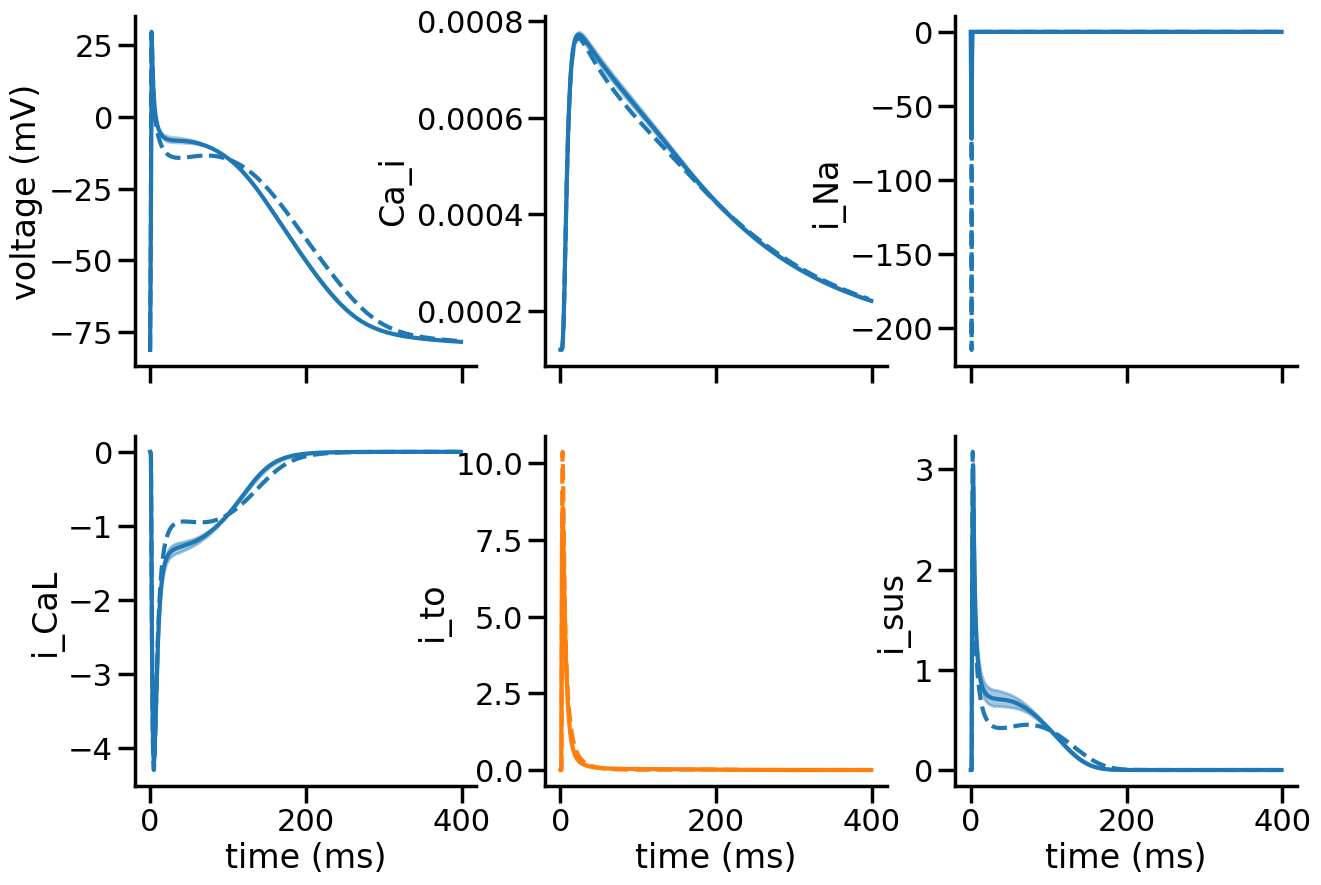

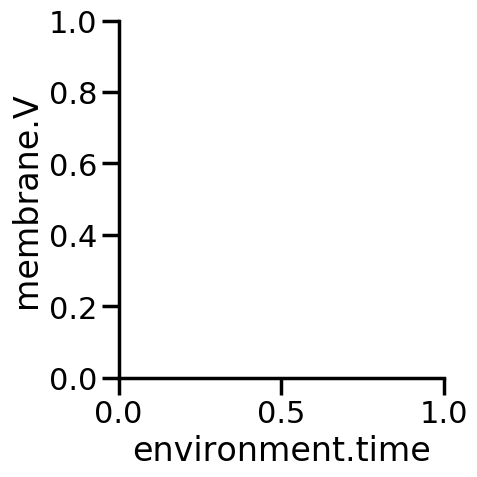

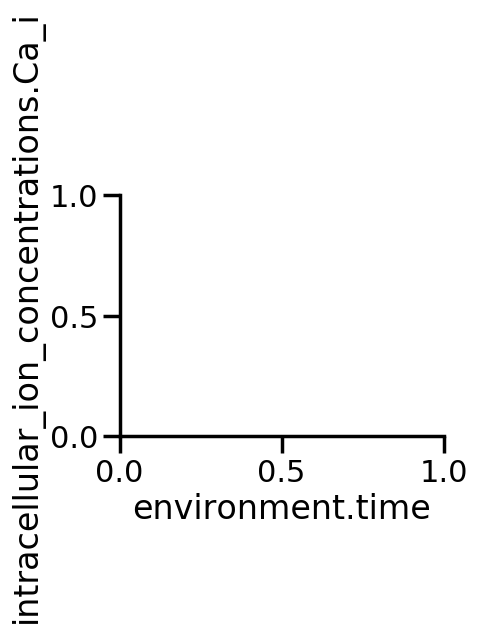

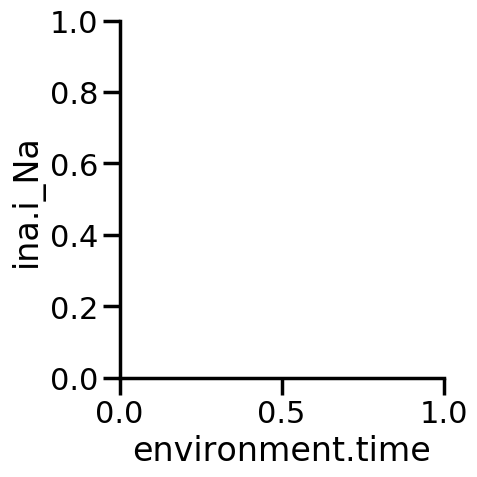

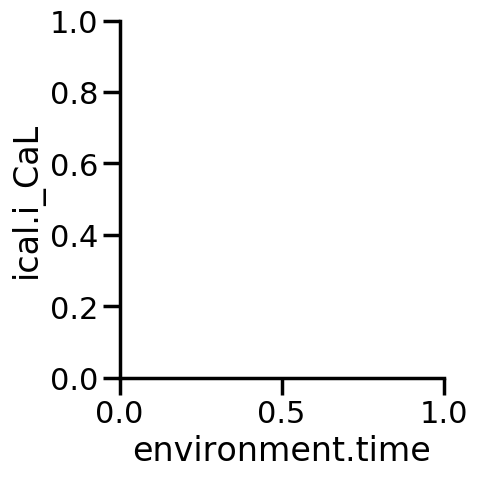

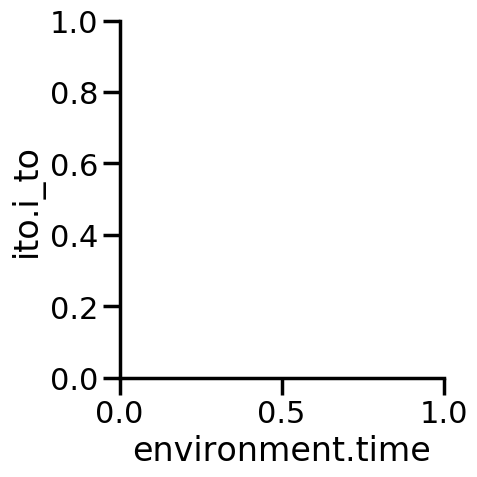

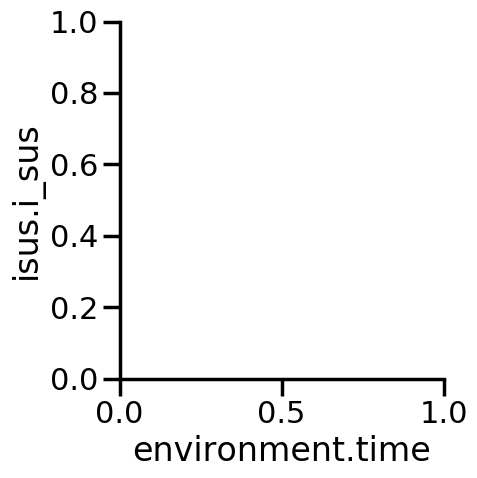

In [1076]:
f = plot_model(cou_s_output_ito, data_cou_original, cou_log_vars, highlight='ito.i_to')
plt.tight_layout()

In [1078]:
#f.savefig('figures/ito/ap_cou_s_ito.pdf')

In [1047]:
# join the dataframes for each case
ap_ito_df = pd.DataFrame({})
ap_ito_df = ap_ito_df.append([nyg_ap_ito, cou_ap_ito, nyg_s_ap_ito, cou_s_ap_ito])
ap_original_df = pd.DataFrame({})
ap_original_df = ap_original_df.append([nyg_ap_original,
                                        cou_ap_original,
                                        nyg_s_ap_original,
                                        cou_s_ap_original])

In [1048]:
ap_original_df

RP         AMP       APD90 model
0 -74.110697  114.301224  223.178334     N
0 -81.172067  110.942165  288.453603     C
0 -74.110697  114.301224  223.178334   N+S
0 -81.172067  110.942165  288.453603   C+S

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


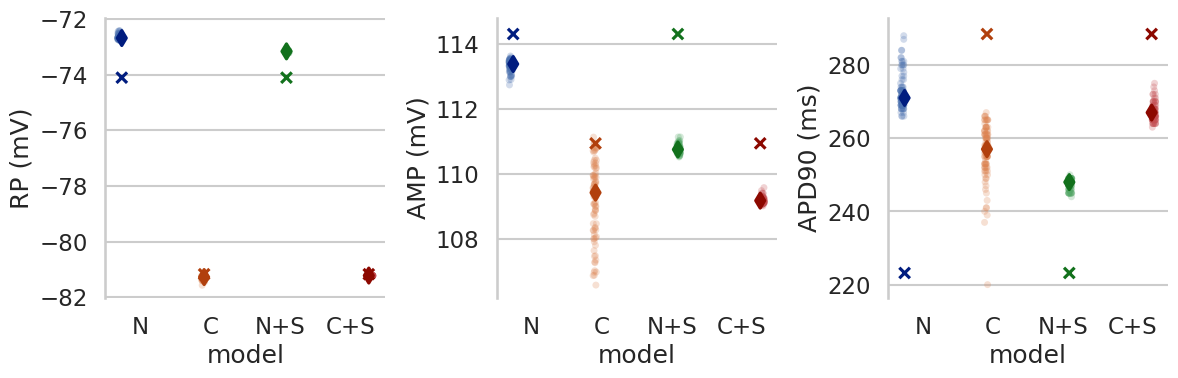

In [1049]:
f = plot_ap_measurements(ap_ito_df, ap_original_df)
plt.tight_layout()

In [1051]:
#f.savefig('figures/ito/ap_measure_ito.pdf')

In [1140]:
ap_plot_ito = pd.DataFrame({})
models = ['N', 'C']
outputs = [nyg_output_ito, cou_output_ito]
for m, o in zip(models, outputs):
    ap_plot_ito = ap_plot_ito.append(
        pd.DataFrame({'time': o['environment.time'],
                      'V': o['membrane.V'],
                      'model': m})
    )

In [1141]:
ap_plot_ito_s = pd.DataFrame({})
models = ['N+S', 'C+S']
outputs = [nyg_s_output_ito, cou_s_output_ito]
for m, o in zip(models, outputs):
    ap_plot_ito_s = ap_plot_ito_s.append(
        pd.DataFrame({'time': o['environment.time'],
                      'V': o['membrane.V'],
                      'model': m})
    )

In [1144]:
current_palette = sns.color_palette()

In [1145]:
new_pal = current_palette[2:4]

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


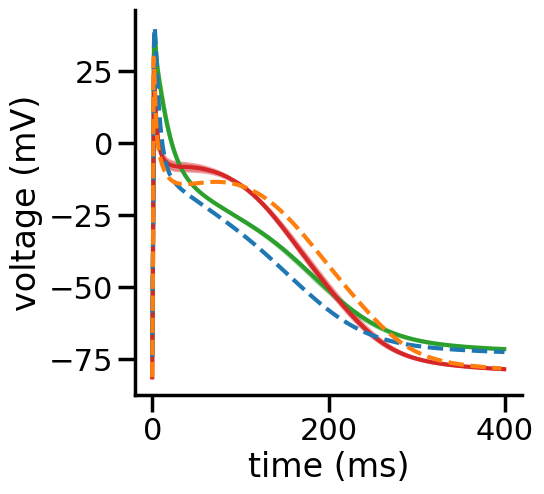

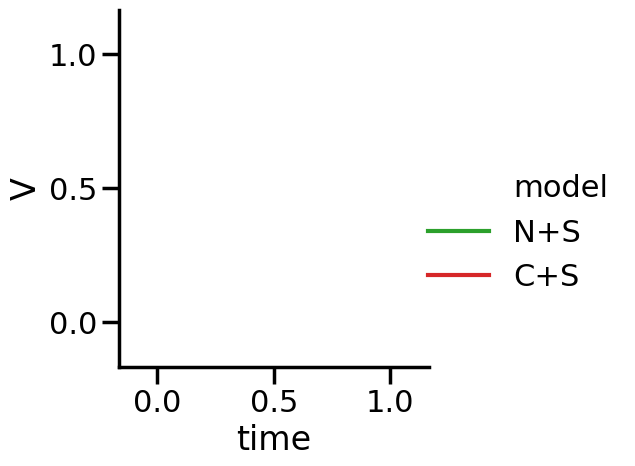

In [1159]:
sns.reset_orig()
sns.set_context('poster')
mpl.rcParams['font.size'] = 14

#data = ap_plot_ito
data = ap_plot_ito_s

fig, ax = plt.subplots(figsize=(5,5))
sns.despine(top=True, right=True)

sns.relplot(x='time', y='V', data=data, hue='model',
            kind='line', estimator=np.median, palette=new_pal,
            ci=None, ax=ax)
for m in data['model'].unique():
    data_m = data[data['model']==m]
    hpd = np.zeros((len(data_m['time'].unique()), 2))
    for j, tj in enumerate(data_m['time'].unique()):
        data_tj = data_m[(data_m['time']==tj)]
        hpd[j,:] = pymc3.hpd(data_tj['V'], credible_interval=0.89)
    color='C0'
    if m=='N':
        color='C0'
    elif m=='C':
        color='C1'
    elif m=='N+S':
        color='C2'
    elif m=='C+S':
        color='C3'
    ax.fill_between(data_m['time'].unique(), hpd[:,0], hpd[:,1], alpha=0.4, color=color)
    if m=='N' or m=='N+S':
        ax.plot(data_nyg_original['environment.time'],
               data_nyg_original['membrane.V'],
               linestyle='--', color='C0')
    elif m=='C' or m=='C+S':
        ax.plot(data_cou_original['environment.time'],
           data_cou_original['membrane.V'],
           linestyle='--', color='C1')
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('voltage (mV)')


In [1160]:
#fig.savefig('figures/ito/ap_ito_NandC_s.pdf')

### $I_\mathrm{sus}$ - NYG

In [918]:
# 1 Hz pacing protocol
npulses = 100
period = 1 # s
duration = 1e-3 # s
level = -2000 # pA -> -2000/50 = -40 pA/pF
offset = 10 # s

pulsetrain_nyg = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

In [919]:
pace = nyg.get('membrane.i_Stim')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
nyg_sim = myokit.Simulation(nyg, pulsetrain_nyg)

In [920]:
# Match peak of i_sus current at step to 60mV

In [921]:
protocol_isus = myokit.pacing.steptrain([60], -50, 10000, 1000)

In [925]:
nyg_model_isus = myokit.load_model('models/nygren_isus.mmt')

In [926]:
pace = nyg_model_isus.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [927]:
nyg_sim_isus = myokit.Simulation(nyg_model_isus, protocol_isus)

In [928]:
data_nyg_isus = nyg_sim_isus.run(protocol_isus.characteristic_time())

In [929]:
original_peak = max(data_nyg_isus['isus.i_sus'], key=abs)

In [931]:
print(original_peak) # pA

385.97349661316855


In [932]:
# test with samples from posterior
h_nyg_r_unified = pyabc.History('sqlite:///results/nygren/isus/unified/nygren_isus_rgate_unified.db')
h_nyg_s_original = pyabc.History('sqlite:///results/nygren/isus/original/nygren_isus_sgate_original.db')

In [933]:
df_nyg_s_original, w_nyg_s_original = h_nyg_s_original.get_distribution(m=0)
df_nyg_r_unified, w_nyg_r_unified = h_nyg_r_unified.get_distribution(m=0)

In [934]:
N = 100
nyg_par_samples_r_unified = df_nyg_r_unified.sample(n=N, weights=w_nyg_r_unified, replace=True)
nyg_par_samples_r_unified = nyg_par_samples_r_unified.set_index([pd.Index(range(N))])
nyg_par_samples_s_original = df_nyg_s_original.sample(n=N, weights=w_nyg_s_original, replace=True)
nyg_par_samples_s_original = nyg_par_samples_s_original.set_index([pd.Index(range(N))])
nyg_samples_isus = (pd.concat([nyg_par_samples_r_unified, 
                                      nyg_par_samples_s_original],axis=1)
                           .to_dict(orient='records'))

In [935]:
peaks = []
for i, sample in enumerate(nyg_samples_isus):
    nyg_sim_isus.reset()
    for p, v in sample.items():
        name = p
        value = v
        if p.startswith("log"):
            name = p[4:]
            value = 10**v
        nyg_sim_isus.set_constant(name, value)
        
    temp_data = nyg_sim_isus.run(protocol_isus.characteristic_time())
    peaks.append(max(temp_data['isus.i_sus'], key=abs))

In [936]:
# multiplier to ensure same over conductance
cond_factors_nyg_isus = [original_peak/p for p in peaks]

In [937]:
print(cond_factors_nyg_isus)

[1.4397527188476853, 0.9900977594893594, 1.2133199812060376, 4.05868179841151, 1.428413468381048, 1.9130167420103674, 1.0589140381450775, 1.0528660058317971, 1.4290238209220527, 1.0429230921481976, 1.285878426491929, 1.0547659041691817, 1.2775883653048634, 1.4546598638254993, 1.1087542153842527, 1.0528358771257564, 0.9892591995040163, 1.0303108610905205, 1.2451706509850688, 1.100591906163043, 1.0878515385837106, 1.892487528389198, 1.1999298933873934, 1.0540504937142336, 1.957283584801797, 1.0800713273996967, 1.0427752533292693, 1.0527637778250185, 2.150502282783405, 0.9958195206033411, 1.0470918974897547, 0.9922589278083817, 2.0660904038207453, 1.1495467706663607, 1.1089211081346448, 0.9962180095185763, 1.0096772923504185, 2.0297867664037685, 1.5511750858774782, 0.9936230760123497, 1.0101819208238971, 1.163566057066765, 2.2939796117108817, 1.3251502088077827, 1.0493824001088856, 1.4326842271154598, 1.383529578351821, 0.9911272658989936, 1.211978724839465, 1.0702655255433122, 1.13586226

In [938]:
nyg_output_isus, nyg_ap_isus = make_output(nyg_sim, pulsetrain_nyg, 'N', 'isus', nyg_samples_isus,
                                           cond_factors_nyg_isus, log_interval=0.001, ap_offset=0.4,
                                           log_vars=nyg_log_vars)

In [939]:
nyg_output_isus['environment.time'] *= 1e3

In [940]:
for var in nyg_log_vars:
    if var.split('.')[1][0]=='i':
        nyg_output_isus[var] /= Cm_nyg

In [941]:
nyg_ap_isus['APD90'] *= 1e3

In [942]:
nyg_ap_isus.median()

RP       -62.184098
AMP       95.027834
APD90    298.000000
dtype: float64

In [1175]:
calc_hpd(nyg_ap_isus)

array([[-62.96954411, -61.35249848],
       [ 94.22186905,  95.8045922 ],
       [295.        , 302.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


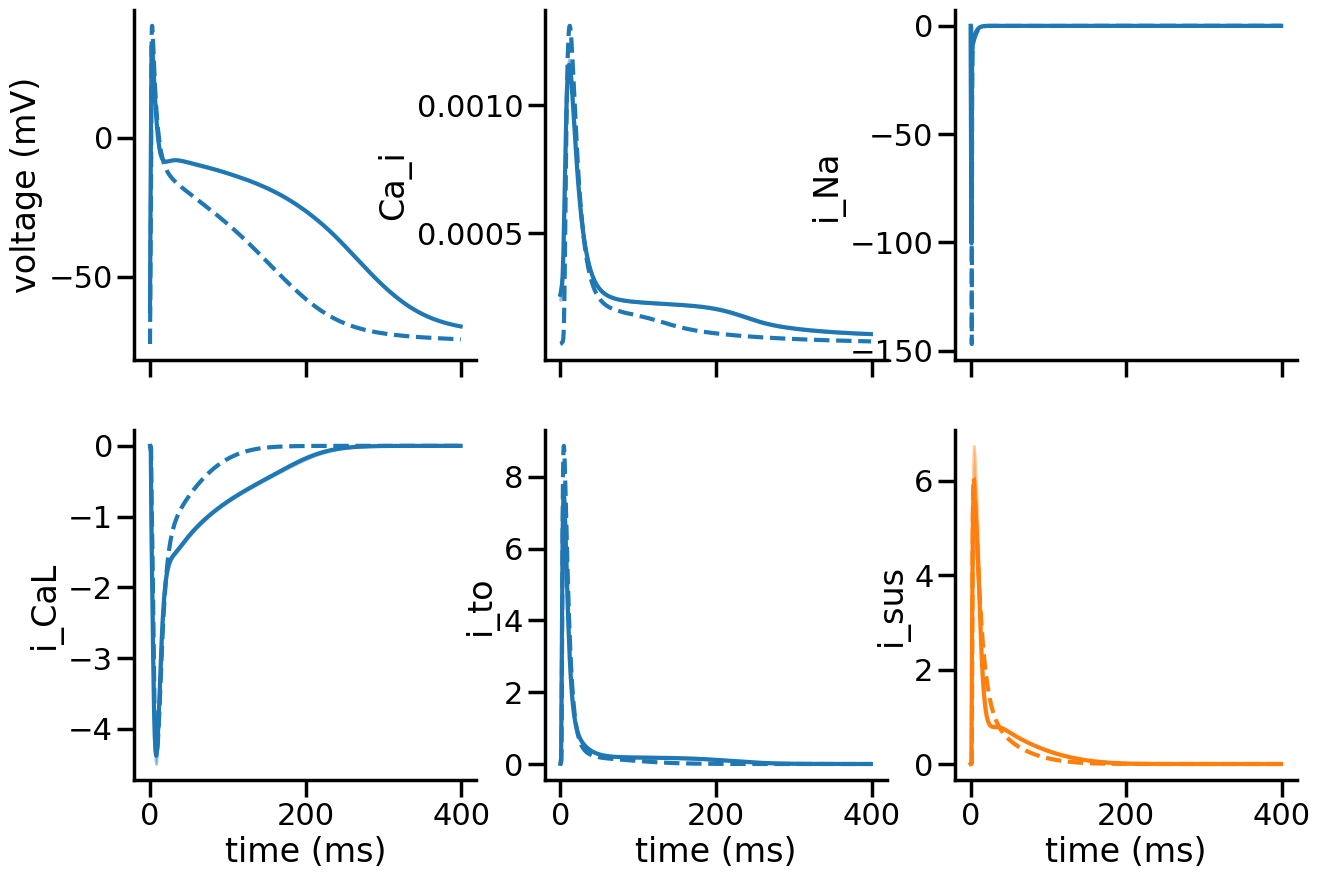

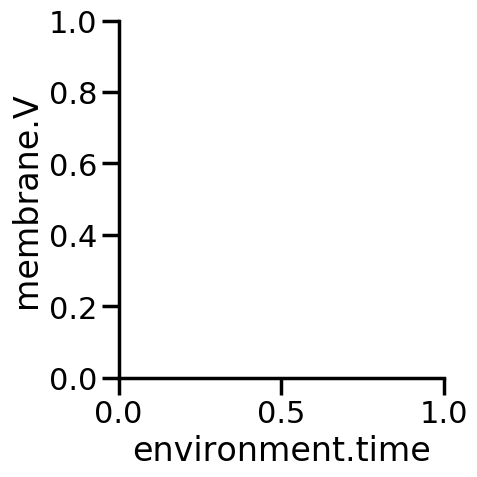

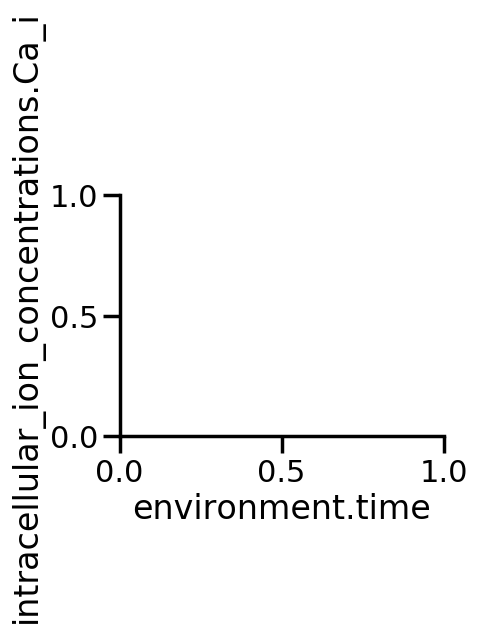

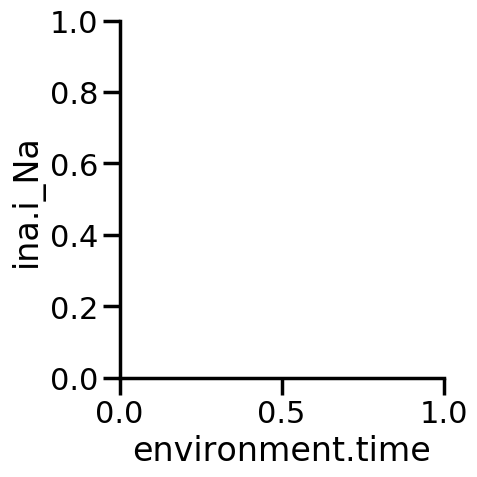

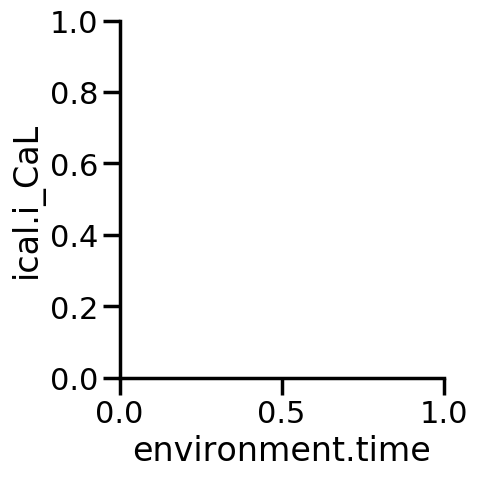

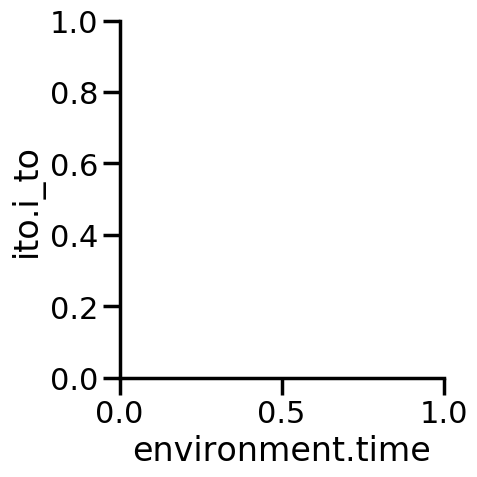

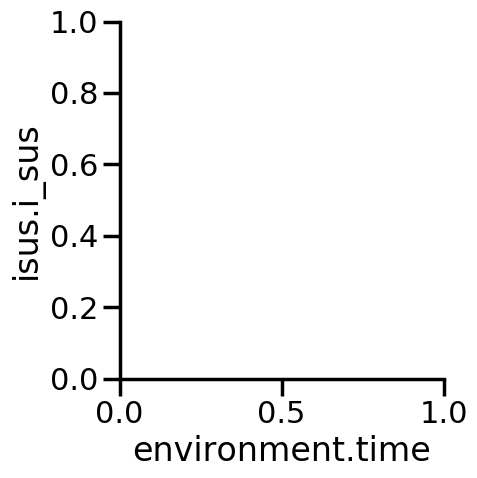

In [1079]:
f = plot_model(nyg_output_isus, data_nyg_original, nyg_log_vars, 'isus.i_sus')
plt.tight_layout()

In [1081]:
#f.savefig('figures/isus/ap_nyg_isus.pdf')

### $I_\mathrm{sus}$ - COU

In [946]:
# 1 Hz pacing protocol
npulses = 100
period = 1000 # ms
duration = 1 # ms
level = -4000 # pA -> -4000/100 = -40 pA/pF
offset = 1e4 # ms

pulsetrain_cou = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

In [947]:
pace = cou.get('membrane.i_st')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
cou_sim = myokit.Simulation(cou, pulsetrain_cou)

In [948]:
# Match peak of i_sus current at step to 60mV

In [949]:
protocol_isus = myokit.pacing.steptrain([60], -50, 10000, 1000)

In [950]:
cou_model_isus = myokit.load_model('models/courtemanche_isus.mmt')

In [951]:
pace = cou_model_isus.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [952]:
cou_sim_isus = myokit.Simulation(cou_model_isus, protocol_isus)

In [953]:
data_cou_isus = cou_sim_isus.run(protocol_isus.characteristic_time())

In [954]:
original_peak = max(data_cou_isus['isus.i_sus'], key=abs)

In [955]:
print(original_peak) # pA/pF

7.473240484801276


In [956]:
# test with samples from posterior
h_cou_a_original = pyabc.History('sqlite:///results/courtemanche/isus/original/courtemanche_isus_agate_original.db')
h_cou_i_unified = pyabc.History('sqlite:///results/courtemanche/isus/unified/courtemanche_isus_igate_unified.db')

In [957]:
df_cou_a_original, w_cou_a_original = h_cou_a_original.get_distribution(m=0)
df_cou_i_unified, w_cou_i_unified = h_cou_i_unified.get_distribution(m=0)

In [958]:
N = 100
cou_par_samples_a_original = df_cou_a_original.sample(n=N, weights=w_cou_a_original, replace=True)
cou_par_samples_a_original = cou_par_samples_a_original.set_index([pd.Index(range(N))])
cou_par_samples_i = df_cou_i_unified.sample(n=N, weights=w_cou_i_unified, replace=True)
cou_par_samples_i = cou_par_samples_i.set_index([pd.Index(range(N))])
cou_samples_isus = pd.concat([cou_par_samples_a_original, cou_par_samples_i],axis=1).to_dict(orient='records')

In [959]:
peaks = []
for i, sample in enumerate(cou_samples_isus):
    cou_sim_isus.reset()
    for p, v in sample.items():
        name = p
        value = v
        if p.startswith("log"):
            name = p[4:]
            value = 10**v
        cou_sim_isus.set_constant(name, value)
        
    temp_data = cou_sim_isus.run(protocol_isus.characteristic_time())
    peaks.append(max(temp_data['isus.i_sus'], key=abs))

In [960]:
# multiplier to ensure same over conductance
cond_factors_cou_isus = [original_peak/p for p in peaks]

In [961]:
print(cond_factors_cou_isus)

[1.1226832616517255, 0.6399897549340137, 0.7628081102881273, 0.5510164409973568, 15.307887648653859, 8.515743664843571, 9.361223397235388, 4.758456837273504, 4.68685910755596, 7.468022423062929, 13.328050093489011, 2.155057033675657, 16.84521400378682, 1.1215541215557994, 0.4703036548892109, 6.922746851242291, 0.6150763518897564, 1.5245022422065957, 0.7292570839287229, 0.8842782380538605, 6.580279349314301, 4.515613427935918, 5.627116943107218, 10.392641375031559, 0.689466306632846, 14.509658741133725, 1.4066025712022954, 2.279234026340959, 6.7192459558762, 3.1741124297785874, 23.7409463682636, 22.854656018171838, 0.6675694398762014, 13.155370445745527, 0.4438822909435752, 6.2235936208693685, 0.29223276051912506, 0.5410177467395167, 13.586511324967605, 0.3125701381751557, 0.49247156419899196, 3.2382327892908913, 0.8573242282476298, 9.245549016552845, 6.904656394686415, 7.212737071074418, 2.0834048033390578, 0.9074288113697796, 4.756836519093172, 2.905844340442724, 7.112621932128498, 5.

In [962]:
cou_output_isus, cou_ap_isus = make_output(cou_sim, pulsetrain_cou, 'C', 'isus', cou_samples_isus,
                                           cond_factors_cou_isus, log_interval=1, ap_offset=400,
                                           log_vars=cou_log_vars)

In [964]:
for var in cou_log_vars:
    if var.split('.')[1][0]=='i':
        cou_output_isus[var] /= Cm_cou

In [965]:
cou_ap_isus.median()

RP       -81.582561
AMP      111.245697
APD90    237.500000
dtype: float64

In [1176]:
calc_hpd(cou_ap_isus)

array([[-81.8402318 , -80.93581915],
       [109.79511566, 111.83065376],
       [190.        , 304.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


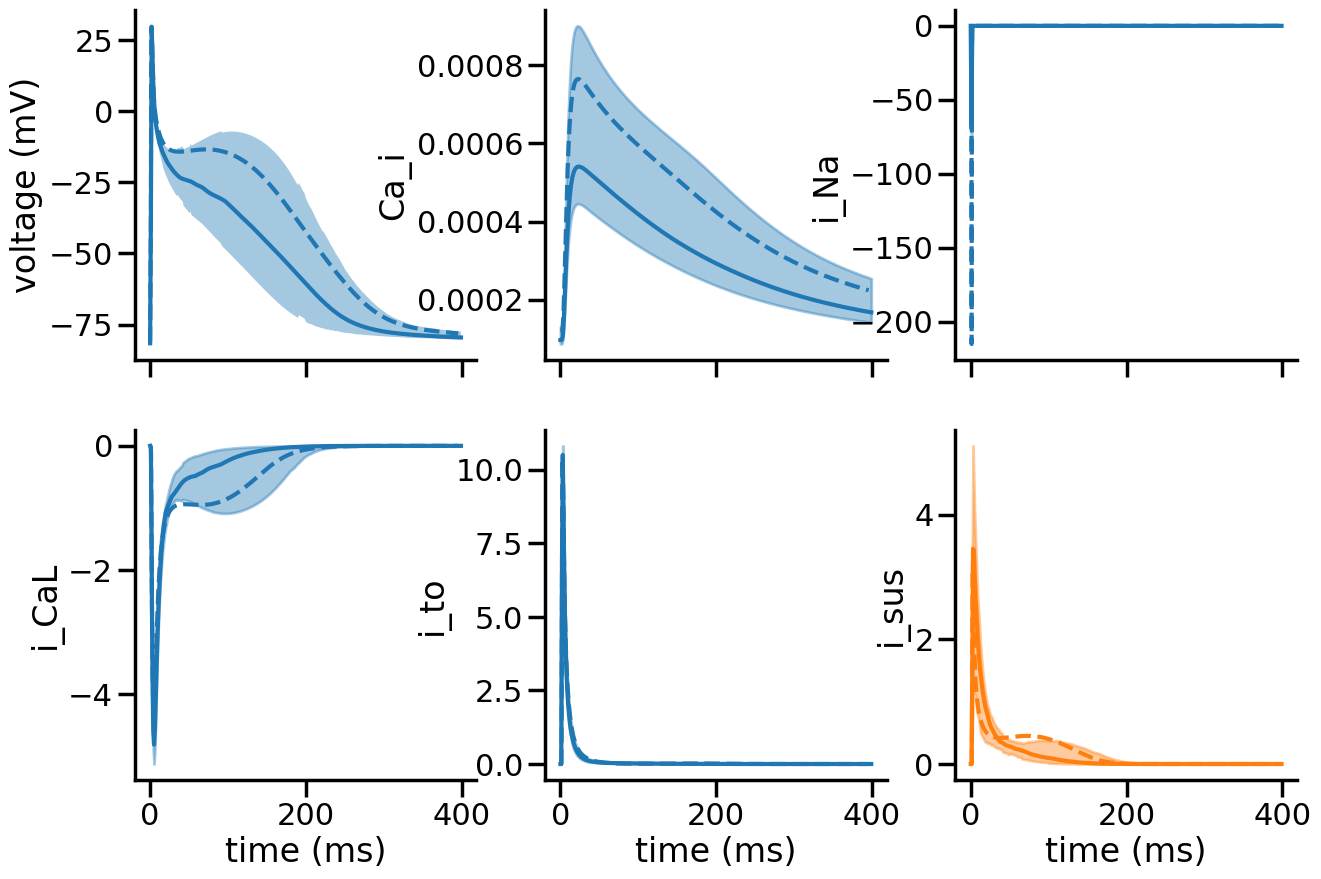

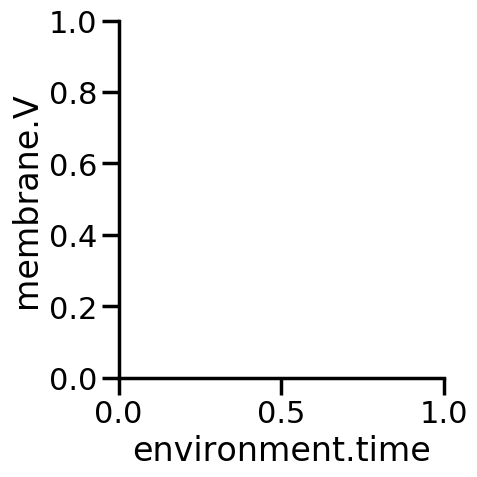

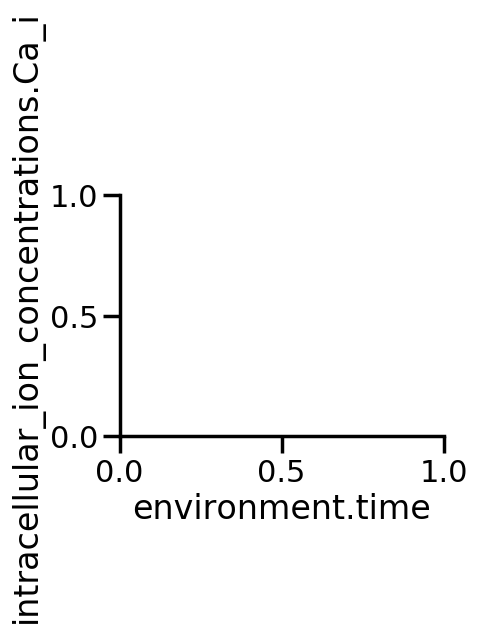

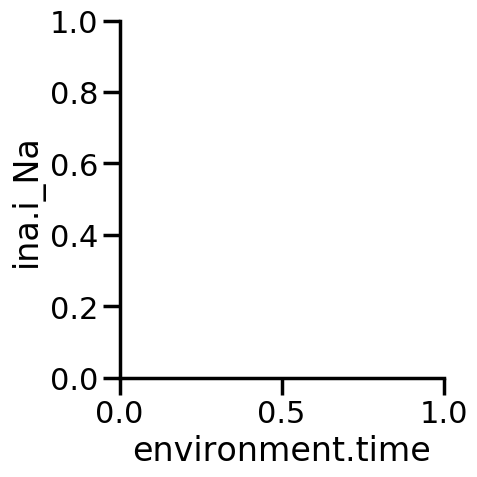

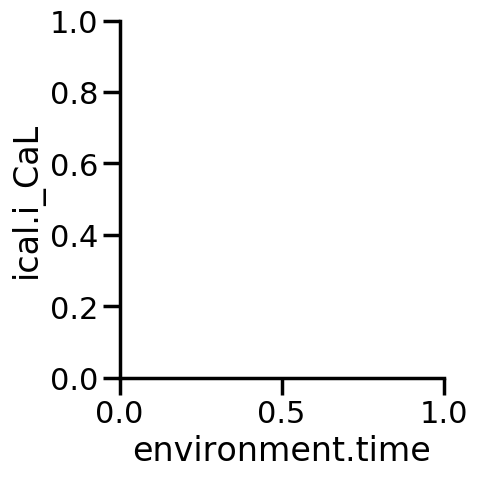

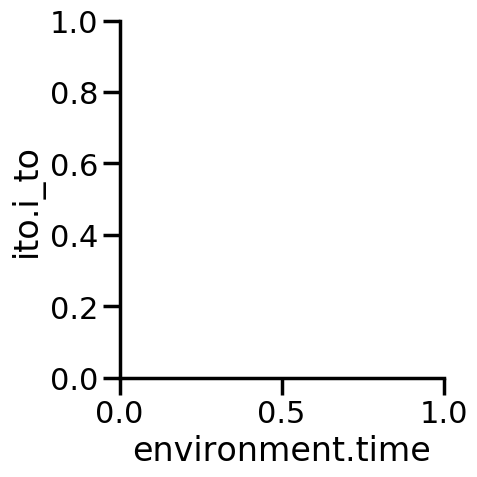

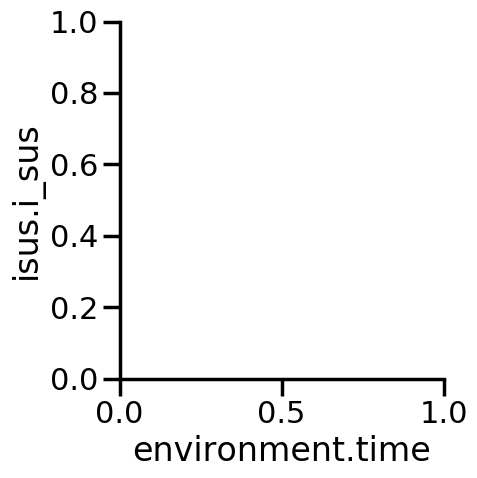

In [1082]:
f = plot_model(cou_output_isus, data_cou_original, cou_log_vars, highlight='isus.i_sus')
plt.tight_layout()

In [1084]:
#f.savefig('figures/isus/ap_cou_isus.pdf')

### $I_\mathrm{sus}$ - NYG+S

In [969]:
nyg_s_isus = myokit.load_model('models/nygren_variability_isus.mmt')

In [970]:
# 1 Hz pacing protocol
npulses = 100
period = 1 # s
duration = 1e-3 # s
level = -2000 # pA -> -2000/50 = -40 pA/pF
offset = 10 # s

pulsetrain_nyg = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = nyg_s_isus.get('membrane.i_Stim')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
nyg_s_isus_sim = myokit.Simulation(nyg_s_isus, pulsetrain_nyg)

In [971]:
# Match peak of i_sus current at step to 60mV

In [972]:
protocol_isus = myokit.pacing.steptrain([60], -50, 10000, 1000)

In [973]:
nyg_model_isus = myokit.load_model('models/nygren_isus.mmt')

In [974]:
pace = nyg_model_isus.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [975]:
nyg_sim_isus = myokit.Simulation(nyg_model_isus, protocol_isus)

In [976]:
data_nyg_isus = nyg_sim_isus.run(protocol_isus.characteristic_time())

In [977]:
original_peak = max(data_nyg_isus['isus.i_sus'], key=abs)

In [979]:
print(original_peak) # pA

385.97349661316855


In [980]:
# test with samples from posterior
h_sta = pyabc.History('sqlite:///results/standardised/isus/standardised_isus.db')
df_sta, w_sta = h_sta.get_distribution(m=0)

In [981]:
N = 100
sta_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
sta_samples = sta_samples.set_index([pd.Index(range(N))])
sta_samples = sta_samples.to_dict(orient='records')

In [982]:
sta_model = myokit.load_model('models/standardised_isus_nyg_temp.mmt')

pace = sta_model.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

sta_sim_isus = myokit.Simulation(sta_model, protocol_isus)

In [983]:
peaks = []
for i, sample in enumerate(sta_samples):
    sta_sim_isus.reset()
    for p, v in sample.items():
        name = p
        value = v
        if p.startswith("log"):
            name = p[4:]
            value = 10**v
        sta_sim_isus.set_constant(name, value)
        
    temp_data = sta_sim_isus.run(protocol_isus.characteristic_time())
    peaks.append(max(temp_data['isus.i_sus'], key=abs))

In [984]:
# multiplier to ensure same over conductance
cond_factors_nyg_s_isus = [original_peak/p for p in peaks]

In [985]:
print(cond_factors_nyg_s_isus)

[67653.54211595167, 57710.02867860487, 18653.280265892838, 29743.715263809485, 56522.747090357116, 67740.13335726103, 29743.715263809485, 64936.416980862814, 66472.27271436354, 52073.28194940075, 17062.300245391183, 72971.60108350914, 75192.72647244205, 55274.48653861644, 41208.79322962904, 55532.508889889774, 49453.2629657866, 75326.56263212734, 73960.17325504925, 51881.784005720125, 72971.60108350914, 46772.50474208196, 98130.15874625205, 83217.77362665052, 53301.51313156645, 51585.98987328746, 68583.58219997761, 7745.000276065994, 7745.000276065994, 54001.488949918705, 52811.92103122421, 42521.61908128686, 61627.402476115836, 70943.23736082962, 68584.44749517132, 52075.68091197828, 107382.04964770707, 25387.70110194706, 45099.758889960656, 60128.46201355696, 7745.000276065994, 50251.819383860246, 51894.52607421133, 80632.69418385167, 55356.744937097144, 23609.212873462086, 63271.30083787445, 40014.691833928475, 43578.6742564589, 67653.54211595167, 16407.128191524527, 69614.946915238

In [986]:
nyg_s_output_isus, nyg_s_ap_isus = make_output(nyg_s_isus_sim, pulsetrain_nyg, 'N+S', 'isus', sta_samples,
                                               cond_factors_nyg_s_isus, log_interval=0.001, ap_offset=0.4,
                                               log_vars=nyg_log_vars)

In [987]:
nyg_s_output_isus['environment.time'] *= 1e3

In [988]:
for var in nyg_log_vars:
    if var.split('.')[1][0]=='i':
        nyg_s_output_isus[var] /= Cm_nyg

In [989]:
nyg_s_ap_isus['APD90'] *= 1e3

In [990]:
nyg_s_ap_isus.median()

RP       -62.202631
AMP       93.868491
APD90    286.000000
dtype: float64

In [1177]:
calc_hpd(nyg_s_ap_isus)

array([[-66.14822486, -57.97212058],
       [ 88.21928354,  98.7683055 ],
       [283.        , 293.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


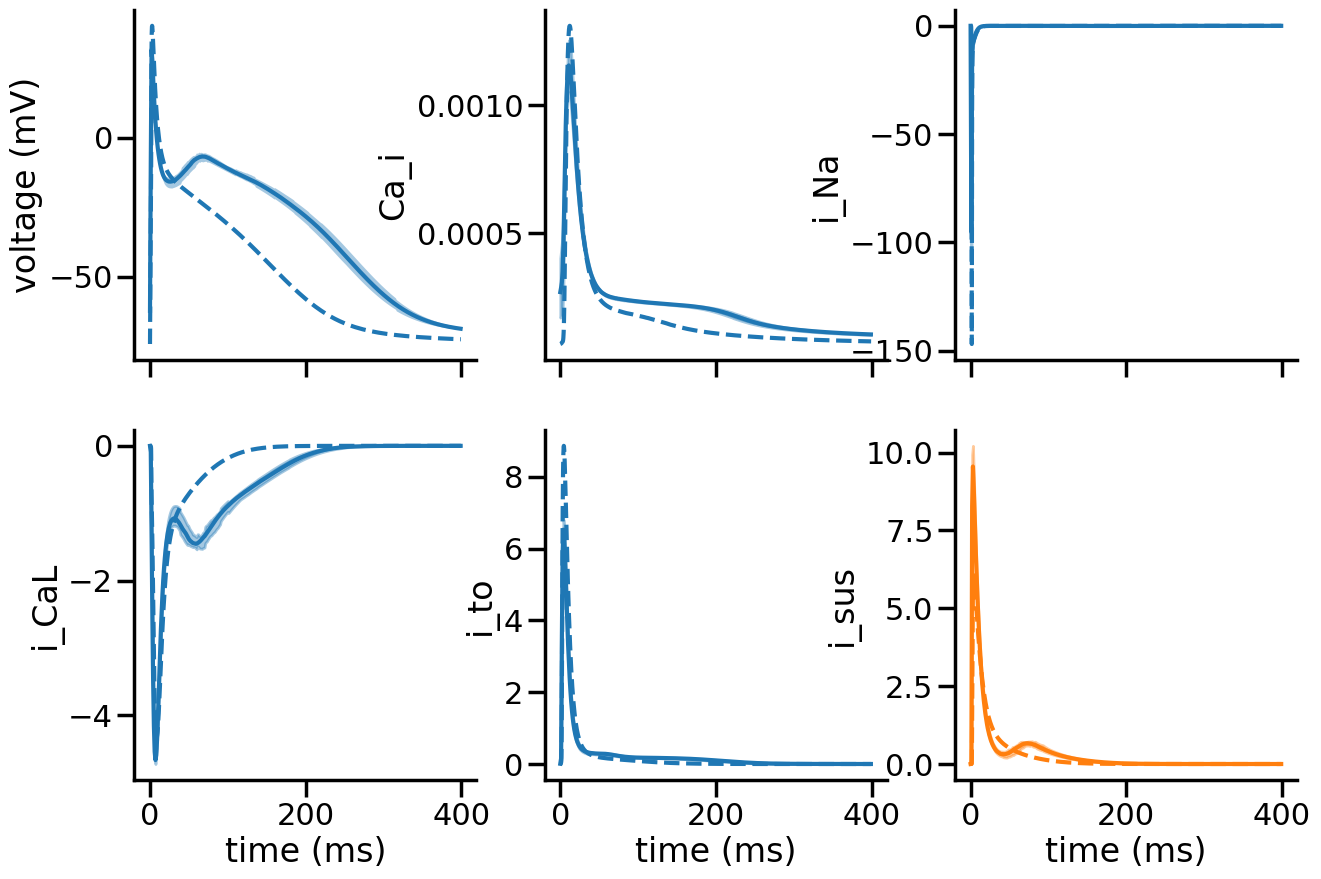

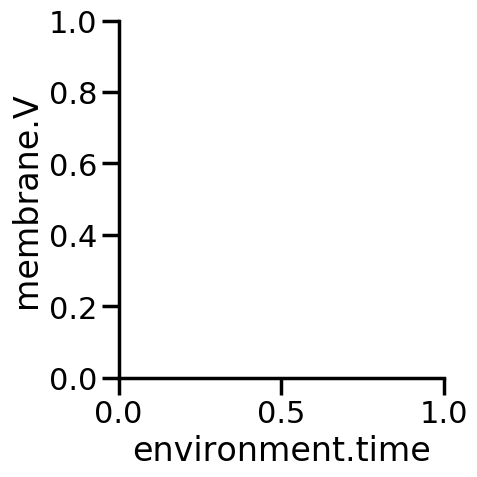

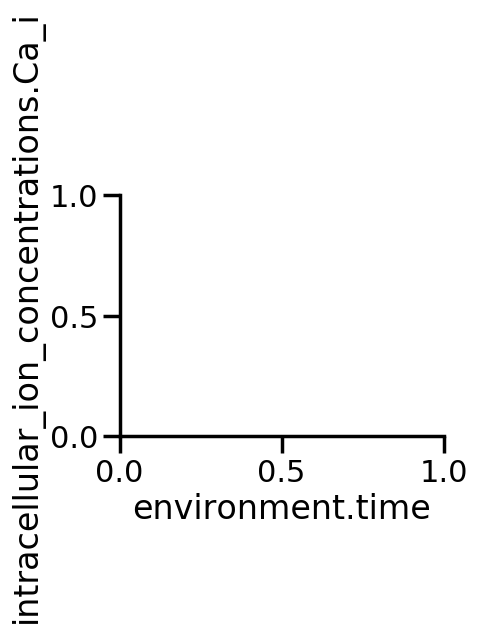

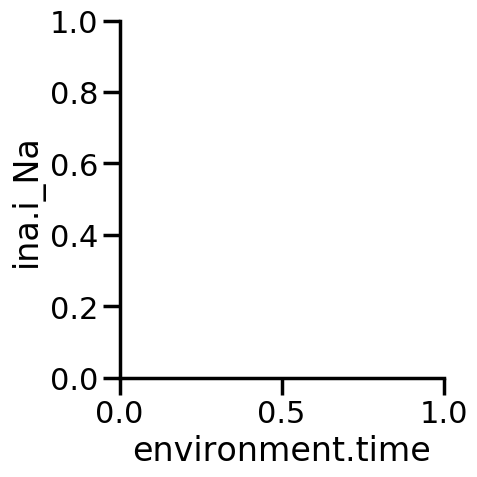

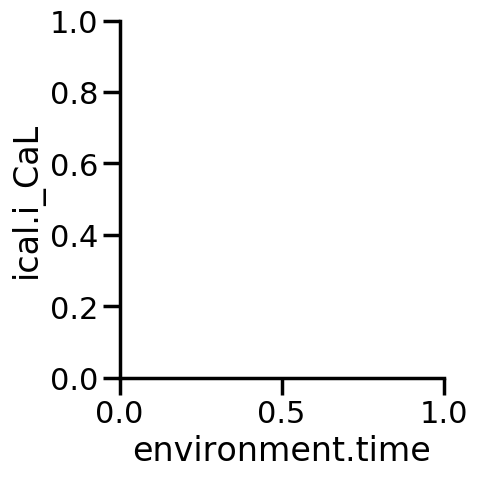

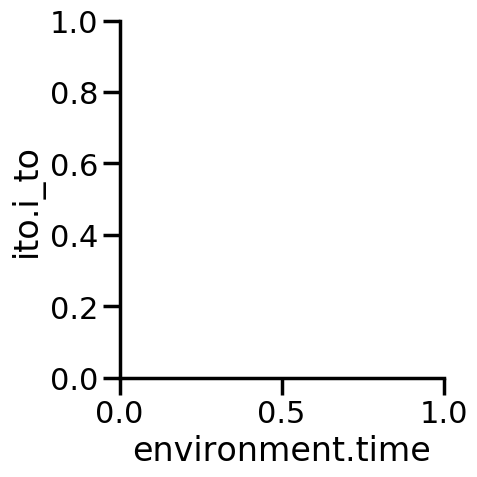

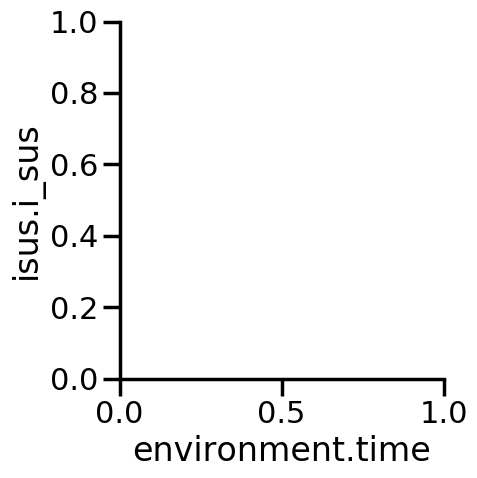

In [1085]:
f = plot_model(nyg_s_output_isus, data_nyg_original, nyg_log_vars, highlight='isus.i_sus')
plt.tight_layout()

In [1087]:
#f.savefig('figures/isus/ap_nyg_s_isus.pdf')

### $I_\mathrm{sus}$ - COU+S

In [994]:
cou_s_isus = myokit.load_model('models/courtemanche_variability_isus.mmt')

In [995]:
# 1 Hz pacing protocol
npulses = 100
period = 1000 # ms
duration = 1 # ms
level = -4000 # pA -> -4000/100 = -40 pA/pF
offset = 1e4 # ms

pulsetrain_cou = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

pace = cou_s_isus.get('membrane.i_st')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
cou_s_isus_sim = myokit.Simulation(cou_s_isus, pulsetrain_cou)

In [996]:
# Match peak of i_to current at step to 60mV

In [997]:
protocol_isus = myokit.pacing.steptrain([60], -50, 10000, 1000)

In [999]:
cou_model_isus = myokit.load_model('models/courtemanche_isus_sta_temp.mmt')

In [1000]:
pace = cou_model_isus.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [1001]:
cou_sim_isus = myokit.Simulation(cou_model_isus, protocol_isus)

In [1002]:
data_cou_isus = cou_sim_isus.run(protocol_isus.characteristic_time())

In [1003]:
original_peak = max(data_cou_isus['isus.i_sus'], key=abs)

In [1005]:
print(original_peak) # pA/pF

7.595440224916314


In [1006]:
# test with samples from posterior
h_sta = pyabc.History('sqlite:///results/standardised/isus/standardised_isus.db')
df_sta, w_sta = h_sta.get_distribution(m=0)

In [1007]:
N = 100
sta_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
sta_samples = sta_samples.set_index([pd.Index(range(N))])
sta_samples = sta_samples.to_dict(orient='records')

In [1008]:
sta_model = myokit.load_model('models/standardised_isus.mmt')

pace = sta_model.get('membrane.V')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

sta_sim_isus = myokit.Simulation(sta_model, protocol_isus)

In [1009]:
peaks = []
for i, sample in enumerate(sta_samples):
    sta_sim_isus.reset()
    for p, v in sample.items():
        name = p
        value = v
        if p.startswith("log"):
            name = p[4:]
            value = 10**v
        sta_sim_isus.set_constant(name, value)
        
    temp_data = sta_sim_isus.run(protocol_isus.characteristic_time())
    peaks.append(max(temp_data['isus.i_sus'], key=abs))

In [1010]:
# multiplier to ensure same over conductance
cond_factors_cou_s_isus = [original_peak/p for p in peaks]

In [1011]:
print(cond_factors_cou_s_ito)

[11.86721323515843, 11.226509936124701, 11.83586640227882, 12.245159429814064, 12.764984054720674, 11.584468799296275, 12.1496096290863, 11.54069126645768, 11.920307134613909, 12.734480128538324, 12.8425806813132, 11.973675484692919, 11.798794322853196, 11.449597550527587, 11.570572138259106, 12.160425952430604, 11.728935983870757, 11.228800433184558, 12.1496096290863, 12.333128351505284, 12.026757915896436, 12.200011161885968, 12.436789809747603, 12.039740143552372, 11.358597687862817, 11.64409528419289, 11.64409528419289, 11.358597687862817, 11.949427338097502, 11.708777968182625, 12.327219380615244, 12.447690388468194, 12.563881259158359, 12.389758517549813, 11.744745867969947, 12.538371882719963, 12.62747527426433, 11.54069126645768, 12.37385691883083, 11.34377551018593, 12.446358155764447, 12.360083053501516, 12.707196235265492, 11.949112553091817, 15.016525011802772, 11.849059126049756, 11.910880151655212, 12.196626601478622, 12.360083053501516, 11.511231578328985, 11.98090561558

In [1012]:
cou_s_output_isus, cou_s_ap_isus = make_output(cou_s_isus_sim, pulsetrain_cou, 'C+S', 'isus', sta_samples,
                                               cond_factors_cou_s_isus, log_interval=1, ap_offset=400,
                                               log_vars=cou_log_vars)

In [1014]:
for var in cou_log_vars:
    if var.split('.')[1][0]=='i':
        cou_s_output_isus[var] /= Cm_cou

In [1015]:
cou_s_ap_isus.median()

RP       -81.906878
AMP      107.608658
APD90    179.500000
dtype: float64

In [1178]:
calc_hpd(cou_s_ap_isus)

array([[-81.99188803, -81.81972829],
       [106.41189987, 108.86565256],
       [150.        , 206.        ]])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


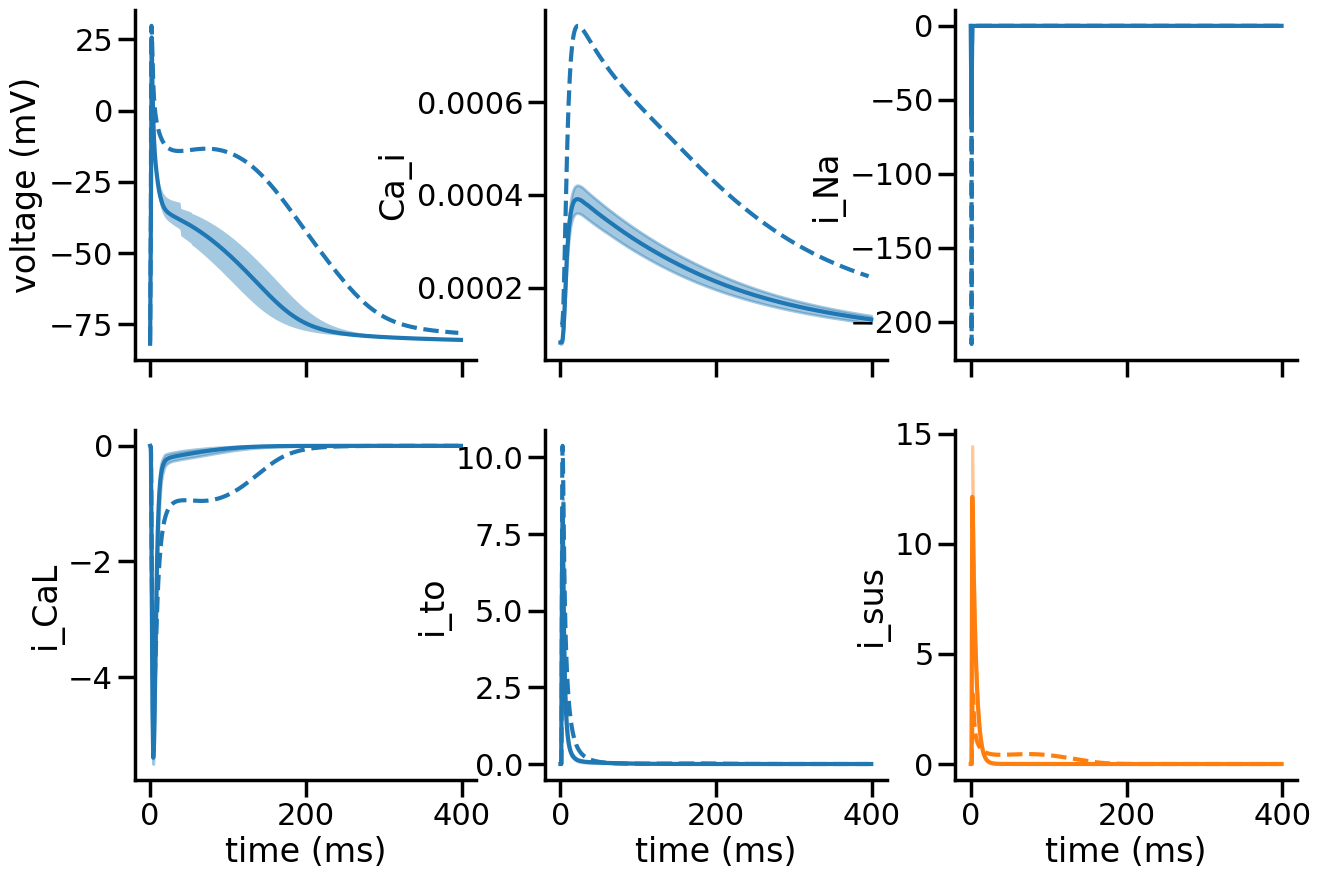

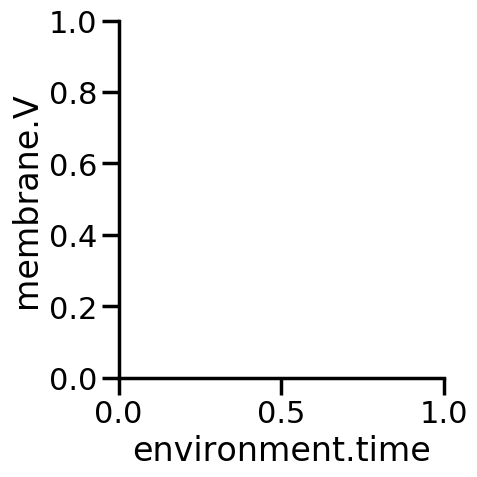

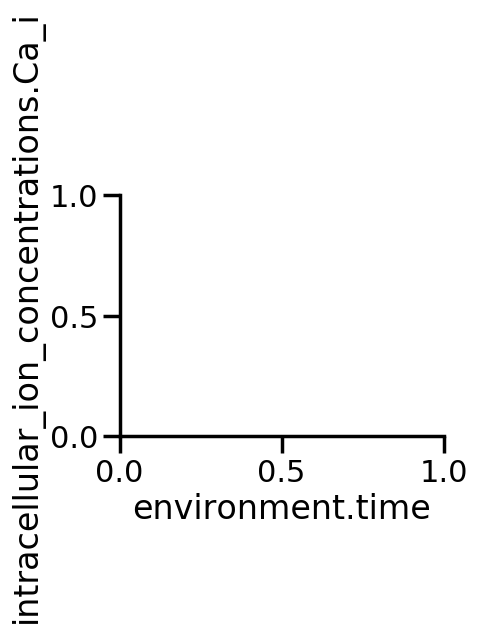

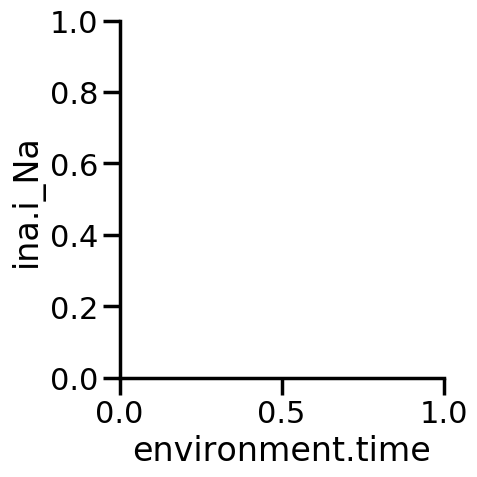

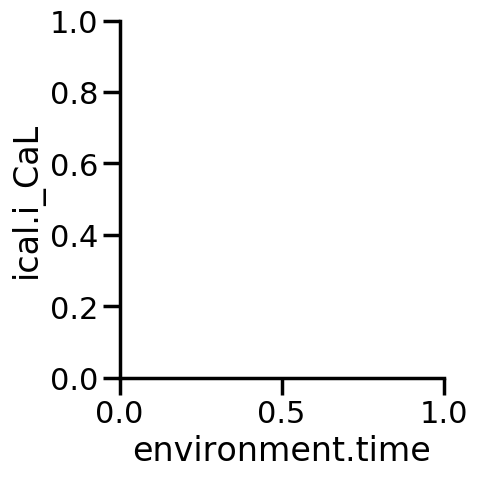

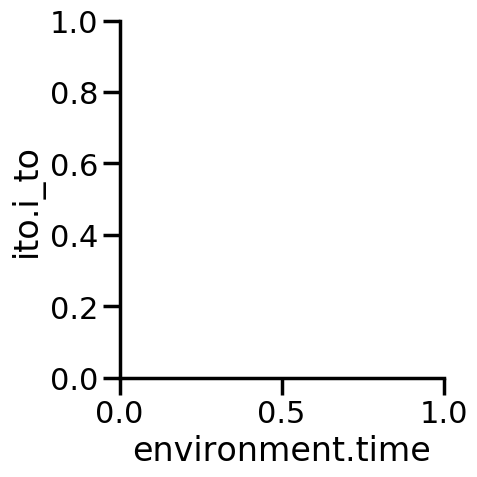

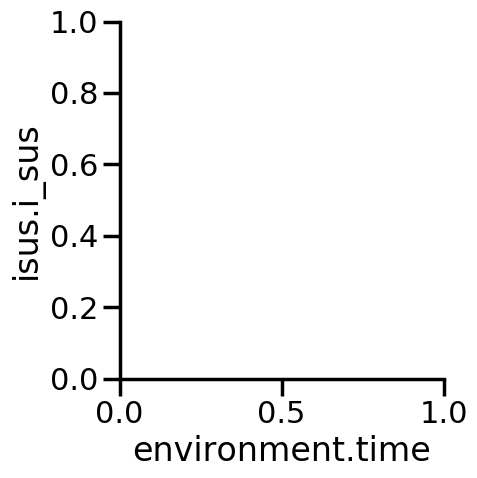

In [1088]:
f = plot_model(cou_s_output_isus, data_cou_original, cou_log_vars, highlight='isus.i_sus')
plt.tight_layout()

In [1090]:
#f.savefig('figures/isus/ap_cou_s_isus.pdf')

In [1019]:
# join the dataframes for each case
ap_isus_df = pd.DataFrame({})
ap_isus_df = ap_isus_df.append([nyg_ap_isus, cou_ap_isus, nyg_s_ap_isus, cou_s_ap_isus])
ap_original_df = pd.DataFrame({})
ap_original_df = ap_original_df.append([nyg_ap_original,
                                        cou_ap_original,
                                        nyg_s_ap_original,
                                        cou_s_ap_original])

In [1020]:
ap_original_df

RP         AMP       APD90 model
0 -74.110697  114.301224  223.178334     N
0 -81.172067  110.942165  288.453603     C
0 -74.110697  114.301224  223.178334   N+S
0 -81.172067  110.942165  288.453603   C+S

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


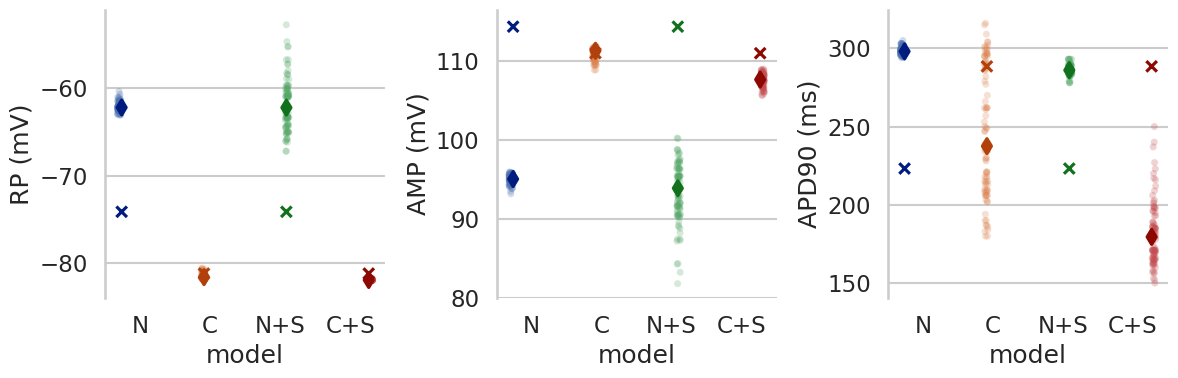

In [1021]:
f = plot_ap_measurements(ap_isus_df, ap_original_df)
plt.tight_layout()

In [1023]:
#f.savefig('figures/isus/ap_measure_isus.pdf')

In [1150]:
ap_plot_isus = pd.DataFrame({})
models = ['N', 'C']
outputs = [nyg_output_isus, cou_output_isus]
for m, o in zip(models, outputs):
    ap_plot_isus = ap_plot_isus.append(
        pd.DataFrame({'time': o['environment.time'],
                      'V': o['membrane.V'],
                      'model': m})
    )

In [1149]:
ap_plot_isus_s = pd.DataFrame({})
models = ['N+S', 'C+S']
outputs = [nyg_s_output_isus, cou_s_output_isus]
for m, o in zip(models, outputs):
    ap_plot_isus_s = ap_plot_isus_s.append(
        pd.DataFrame({'time': o['environment.time'],
                      'V': o['membrane.V'],
                      'model': m})
    )

In [1153]:
current_palette = sns.color_palette()

In [1154]:
new_pal = current_palette[2:4]

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


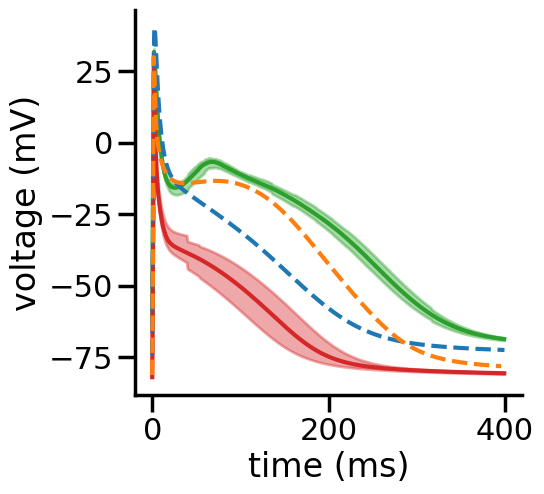

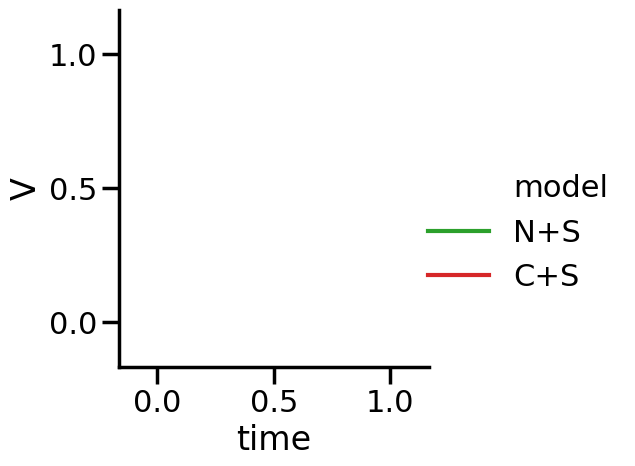

In [1157]:
sns.reset_orig()
sns.set_context('poster')
mpl.rcParams['font.size'] = 14

#data = ap_plot_isus
data = ap_plot_isus_s

fig, ax = plt.subplots(figsize=(5,5))
sns.despine(top=True, right=True)

sns.relplot(x='time', y='V', data=data, hue='model',
            kind='line', estimator=np.median, palette=new_pal,
            ci=None, ax=ax)
for m in data['model'].unique():
    data_m = data[data['model']==m]
    hpd = np.zeros((len(data_m['time'].unique()), 2))
    for j, tj in enumerate(data_m['time'].unique()):
        data_tj = data_m[(data_m['time']==tj)]
        hpd[j,:] = pymc3.hpd(data_tj['V'], credible_interval=0.89)
    color='C0'
    if m=='N':
        color='C0'
    elif m=='C':
        color='C1'
    elif m=='N+S':
        color='C2'
    elif m=='C+S':
        color='C3'
    ax.fill_between(data_m['time'].unique(), hpd[:,0], hpd[:,1], alpha=0.4, color=color)
    if m=='N' or m=='N+S':
        ax.plot(data_nyg_original['environment.time'],
               data_nyg_original['membrane.V'],
               linestyle='--', color='C0')
    elif m=='C' or m=='C+S':
        ax.plot(data_cou_original['environment.time'],
           data_cou_original['membrane.V'],
           linestyle='--', color='C1')
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('voltage (mV)')


In [1158]:
#fig.savefig('figures/isus/ap_isus_NandC_s.pdf')